# TFG Matemáticas computacionales

## Tabla de contenidos

[1. Preanálisis](#pre)<br>

[2. Descarga,  exploración  y transformación de dataset](#desc)<br>

[3. Predicción de series temporales](#tspred)
- [ARIMA](#ARIMA)
- [LSTM](#lstm)
- [Prophet](#prophet)<br>

[4. Comparativa de modelos](#comp)<br>

[5. Conclusiones](#concl)

## <a id= 'pre'> Preanálisis </a>

### Librerías

In [1]:
import numpy as np
import pandas as pd
import platform 

import matplotlib as mlb
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import KPSSTest, ADFTest

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import keras as krs
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout 

import prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

#### Versiones librerías

In [2]:
versiones = {
    'Python':platform,
    'Numpy': np,
    'Pandas': pd,
    'Matplotlib': mlb,
    'Seaborn': sns,
    'Statsmodels': sm,
    'Pmdarima': pm,
    'Sklearn': skl,
    'Keras': krs,
    'Tensorflow': tf,
    'Prophet': prophet,
}
for key, value in versiones.items():
    if key == 'Python':
        print(f'Version {key}: {value.python_version()}')
    else:
        print(f'Versión {key}: {value.__version__}')

Version Python: 3.7.13
Versión Numpy: 1.21.6
Versión Pandas: 1.3.5
Versión Matplotlib: 3.5.2
Versión Seaborn: 0.11.2
Versión Statsmodels: 0.11.0
Versión Pmdarima: 2.0.4
Versión Sklearn: 1.0.2
Versión Keras: 2.11.0
Versión Tensorflow: 2.11.0
Versión Prophet: 1.1.5


### Colores

In [3]:
# Colores para usar en gráficas
AZUL_OSCURO = (50/255, 80/255, 255/255)
AZUL_TFG =  (66/255,145/255,253/255)
ARIMA_color = (0/255, 255/255, 54/255)
LSTM_color = (220/255, 23/255, 0/255)
PROPHET_color = (54/255, 20/255, 171/255)
TRAIN_color = (1/255, 115/255, 51/255)
TEST_color = (243/255, 166/255, 55/255)

## <a id = 'desc'> Descarga, exploración y transformación del dataset </a>

In [4]:
dataset = pd.read_csv('datasets/productividad_laboral_europa.csv')

In [5]:
dataset

,LOCATION,Country,VARIABLE,Variable,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,PDTY,"Labour productivity, total economy",Q,Quarterly,1964-Q1,Q1-1964,IDX,Index,0,Units,2015,2015,0.464954,NaN,NaN
1,AUS,Australia,PDTY,"Labour productivity, total economy",Q,Quarterly,1964-Q2,Q2-1964,IDX,Index,0,Units,2015,2015,0.474359,NaN,NaN
2,AUS,Australia,PDTY,"Labour productivity, total economy",Q,Quarterly,1964-Q3,Q3-1964,IDX,Index,0,Units,2015,2015,0.475283,NaN,NaN
3,AUS,Australia,PDTY,"Labour productivity, total economy",Q,Quarterly,1964-Q4,Q4-1964,IDX,Index,0,Units,2015,2015,0.484484,NaN,NaN
4,AUS,Australia,PDTY,"Labour productivity, total economy",Q,Quarterly,1965-Q1,Q1-1965,IDX,Index,0,Units,2015,2015,0.471747,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4863,OTO,OECD - Total,PDTY,"Labour productivity, total economy",Q,Quarterly,2020-Q4,Q4-2020,IDX,Index,0,Units,2015,2015,1.038770,NaN,NaN
4864,OTO,OECD - Total,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q1,Q1-2021,IDX,Index,0,Units,2015,2015,1.041489,NaN,NaN
4865,OTO,OECD - Total,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q2,Q2-2021,IDX,Index,0,Units,2015,2015,1.044293,NaN,NaN
4866,OTO,OECD - Total,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q3,Q3-2021,IDX,Index,0,Units,2015,2015,1.046458,NaN,NaN


Con un primer vistazo al *dataset*, se pueden ver algunas cosas importantes:
- La variable a tratar, se puede ver en la columna `Variable` que es la **productividad**.
- La periodicidad de los datos se puede ver en la columna `Frequency` y/o `FREQUENCY`, la cual es trimestral. 
- A primera vista, por las columnas `Time` y/o `TIME`, parece que hay datos desde $1960$ hasta $2021$, pero como son de distintos países (columna `Country`) no se puede asegurar esto último.
- Por último, de este primer vistazo se destaca también el valor de la variable en la columna `Value`. **Esta será la variable objetivo de este trabajo**.


<br>

Del resto de columnas, la única que interesa conocer para este trabajo algo más a fondo es la columna de `Country`. Interesa saber qué valores tiene y qué fechas hay asociadas a estos valores. Esto es lo que se va a ver a continuación.

In [6]:
dataset['Country'].unique()

array(['Australia', 'Canada', 'France', 'Ireland', 'Italy', 'New Zealand',
       'Portugal', 'United States', 'Estonia', 'Lithuania', 'Israel',
       'United Kingdom', 'Belgium', 'Japan', 'Iceland',
       'Euro area (17 countries)', 'Netherlands', 'Czechia', 'Germany',
       'Norway', 'Finland', 'Luxembourg', 'Korea', 'Sweden',
       'OECD - Total'], dtype=object)

Aquí se se ve que mayoritariamente hay países de la Unión Europea (UE). Luego hay otros valores como `Korea`, `United States`, `OECD - Total`, etc. 

Se va a ver ahora cuántos valores hay de cada uno de estos países para ver si hay aproximadamente los mismos para cada uno de ellos. Para ello, como solo se quieren tener en cuenta las filas cuyo `Value` sea distinto de `NaN`, se *checkea* esto primero.

In [7]:
dataset[dataset['Value'].isna()].count()

LOCATION                 0
Country                  0
VARIABLE                 0
Variable                 0
FREQUENCY                0
Frequency                0
TIME                     0
Time                     0
Unit Code                0
Unit                     0
PowerCode Code           0
PowerCode                0
Reference Period Code    0
Reference Period         0
Value                    0
Flag Codes               0
Flags                    0
dtype: int64

Ningún país tiene un valor `NaN` asociado a su columna. A continuación, se va a comprobar lo que se mencionó anteriormente: cuántas filas de cada país hay en el *dataset*.

In [8]:
# Si hubiera valores NA
#dataset.loc[dataset['Value'].notna(),'Country'].value_counts()

In [9]:
dataset['Country'].value_counts()

Belgium                     248
Portugal                    248
Sweden                      248
Finland                     248
Japan                       248
United States               248
OECD - Total                248
France                      248
Italy                       248
Canada                      244
Australia                   232
Iceland                     232
Netherlands                 212
Norway                      208
Korea                       208
United Kingdom              204
Luxembourg                  148
New Zealand                 132
Ireland                     128
Euro area (17 countries)    124
Germany                     124
Czechia                     116
Israel                      108
Estonia                     108
Lithuania                   108
Name: Country, dtype: int64

En el primer vistazo al *dataset*, se ha mencionado que había datos desde $1960$ hasta $2021$ y que eran trimestrales. Es decir, que por cada año hay $4$ datos. Como hay $62$ años entre $1960$ y $2021$ (ambos incluidos) y hay $4$ datos por año: $ 62 \times 4 = 248$. Es decir, que todos aquellos países con $248$ datos de la fila de arriba tienen datos completos: desde $1960$ hasta $2021$ ambos incluidos.

Antes de seguir estudiando el *dataset* un poco más a fondo, se van a eliminar aquellos países que no pertenezcan a la Unión Europea.

In [10]:
paises_UE = ['Belgium', 'Portugal', 'Sweden', 'Finland', 'France',
            'Italy', 'Iceland', 'Netherlands', 'Norway', 'Luxembourg',
            'Ireland', 'Germany', 'Czechia', 'Estonia','Lithuania']

dataset_UE = dataset[dataset['Country'].isin(paises_UE)]
dataset_UE

,LOCATION,Country,VARIABLE,Variable,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
476,FRA,France,PDTY,"Labour productivity, total economy",Q,Quarterly,1960-Q1,Q1-1960,IDX,Index,0,Units,2015,2015,0.282069,NaN,NaN
477,FRA,France,PDTY,"Labour productivity, total economy",Q,Quarterly,1960-Q2,Q2-1960,IDX,Index,0,Units,2015,2015,0.288906,NaN,NaN
478,FRA,France,PDTY,"Labour productivity, total economy",Q,Quarterly,1960-Q3,Q3-1960,IDX,Index,0,Units,2015,2015,0.293645,NaN,NaN
479,FRA,France,PDTY,"Labour productivity, total economy",Q,Quarterly,1960-Q4,Q4-1960,IDX,Index,0,Units,2015,2015,0.296724,NaN,NaN
480,FRA,France,PDTY,"Labour productivity, total economy",Q,Quarterly,1961-Q1,Q1-1961,IDX,Index,0,Units,2015,2015,0.300907,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,SWE,Sweden,PDTY,"Labour productivity, total economy",Q,Quarterly,2020-Q4,Q4-2020,IDX,Index,0,Units,2015,2015,1.035909,NaN,NaN
4616,SWE,Sweden,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q1,Q1-2021,IDX,Index,0,Units,2015,2015,1.037994,NaN,NaN
4617,SWE,Sweden,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q2,Q2-2021,IDX,Index,0,Units,2015,2015,1.040085,NaN,NaN
4618,SWE,Sweden,PDTY,"Labour productivity, total economy",Q,Quarterly,2021-Q3,Q3-2021,IDX,Index,0,Units,2015,2015,1.042278,NaN,NaN


Se prueba si todo está bien, porque puede ser haya que modificar la cadena de texto de la columna `Country` (e.g. puede ser que haya un string como '$\hspace{3pt}$  France $\hspace{3pt}$').

In [11]:
print(f'El número de países almacenados en la variable '\
     f'\033[1mpaíses_UE\033[0m son {len(paises_UE)}; mientras que '\
     f'el número de países en el \033[1mdataset\033[0m es de '\
     f'{len(dataset_UE["Country"].unique())}.\n\n')

if len(paises_UE) == len(dataset_UE["Country"].unique()):
    print('Luego, son iguales y \033[1mno hay que hacer\033[0m ninguna '\
         'modificación en la variable \033[1mCountry\033[0m')
else:
    print('Luego, son diferentes y \033[1mhay que\033[0m hacer '\
         'modificaciones en la variable \033[1mCountry\033[0m')

El número de países almacenados en la variable países_UE son 15; mientras que el número de países en el dataset es de 15.


Luego, son iguales y no hay que hacer ninguna modificación en la variable Country


Una vez se tiene ya el *dataset* con los países correctos, se van a eliminar las columnas que no interesan para este trabajo. Asimismo, se modificará el nombre de alguna de las columnas importantes para que se entienda mejor.

In [12]:
# Se eliminan columnas innecesarias para el trabajo
columnas_importantes = ['Country', 'Time', 'Value']
columnas_a_eliminar = []
for COLUMNA in dataset_UE.columns:
    if COLUMNA not in columnas_importantes:
        dataset_UE.drop(columns = COLUMNA, inplace = True)

In [13]:
dataset_UE

,Country,Time,Value
476,France,Q1-1960,0.282069
477,France,Q2-1960,0.288906
478,France,Q3-1960,0.293645
479,France,Q4-1960,0.296724
480,France,Q1-1961,0.300907
...,...,...,...
4615,Sweden,Q4-2020,1.035909
4616,Sweden,Q1-2021,1.037994
4617,Sweden,Q2-2021,1.040085
4618,Sweden,Q3-2021,1.042278


In [14]:
# Se resetea el indice
dataset_UE.reset_index(drop = True, inplace = True)
dataset_UE

,Country,Time,Value
0,France,Q1-1960,0.282069
1,France,Q2-1960,0.288906
2,France,Q3-1960,0.293645
3,France,Q4-1960,0.296724
4,France,Q1-1961,0.300907
...,...,...,...
2867,Sweden,Q4-2020,1.035909
2868,Sweden,Q1-2021,1.037994
2869,Sweden,Q2-2021,1.040085
2870,Sweden,Q3-2021,1.042278


In [15]:
# Se modifica el nombre de las columnas para que sea más claro
dataset_UE.rename(columns = {'Country': 'Pais', 'Time':'Fecha', 
                             'Value':'Productividad'}, inplace = True)
dataset_UE

,Pais,Fecha,Productividad
0,France,Q1-1960,0.282069
1,France,Q2-1960,0.288906
2,France,Q3-1960,0.293645
3,France,Q4-1960,0.296724
4,France,Q1-1961,0.300907
...,...,...,...
2867,Sweden,Q4-2020,1.035909
2868,Sweden,Q1-2021,1.037994
2869,Sweden,Q2-2021,1.040085
2870,Sweden,Q3-2021,1.042278


Ahora, se van a estudiar las fechas mínimas y máximas que se tienen de cada país. Para ello, se va a agrupar el `dataset_UE` por países y mostrar la primera y última fila, pues parece que las fechas están por orden.

In [16]:
paises = dataset_UE.groupby(by = 'Pais')

In [17]:
for _, PAIS in paises:
    print(f'\033[1m{PAIS.iloc[0,dataset_UE.columns.get_loc("Pais")]}\033[0m')
    print (PAIS.iloc[0,dataset_UE.columns.get_loc('Fecha')])
    print(PAIS.iloc[-1,dataset_UE.columns.get_loc('Fecha')])
    print('\n-----------------------------------------------')
    print('-----------------------------------------------\n')

Belgium
Q1-1960
Q4-2021

-----------------------------------------------
-----------------------------------------------

Czechia
Q1-1993
Q4-2021

-----------------------------------------------
-----------------------------------------------

Estonia
Q1-1995
Q4-2021

-----------------------------------------------
-----------------------------------------------

Finland
Q1-1960
Q4-2021

-----------------------------------------------
-----------------------------------------------

France
Q1-1960
Q4-2021

-----------------------------------------------
-----------------------------------------------

Germany
Q1-1991
Q4-2021

-----------------------------------------------
-----------------------------------------------

Iceland
Q1-1964
Q4-2021

-----------------------------------------------
-----------------------------------------------

Ireland
Q1-1990
Q4-2021

-----------------------------------------------
-----------------------------------------------

Italy
Q1-1960
Q4-2021

--

Aquí se ha podido ver de manera mucho más clara que las fechas sobre las que se tienen datos de cada país es diferente. Pese a que se tengan datos de todos los países hasta el año $2021$, la fecha inicial sobre la que se tienen datos difiere de un país a otro. 

Entonces, para generar una **serie temporal** para los países de Europa, lo que se hará es crear un *dataset* cuya columna `Productividad` sea la productividad media de los países sobre los que se tienen datos un trimestre determinado de un año en concreto. 

In [18]:
serie_temporal_productividad = dataset_UE.groupby('Fecha')\
.mean('Productividad')

In [19]:
serie_temporal_productividad

,Productividad
Fecha,
Q1-1960,0.284764
Q1-1961,0.299138
Q1-1962,0.316134
Q1-1963,0.329212
Q1-1964,0.358506
...,...
Q4-2017,1.034465
Q4-2018,1.037383
Q4-2019,1.046350


Como se puede ver en el índice del dataframe de arriba, el `groupby` no está cogiendo el orden correcto de fecha (lo ordena por años). Lo que se va a hacer es parsear esta columna a un formato `datetime`. Para ello:

- Primero se crea un diccionario que asocie un cuatrimestre con un mes:
    - Q1 $\rightarrow$ Marzo $\rightarrow$ 3
    - Q2 $\rightarrow$ Junio $\rightarrow$ 6
    - Q3 $\rightarrow$ Septiembre $\rightarrow$ 9
    - Q4 $\rightarrow$ Diciembre $\rightarrow$ 12
    
Siendo los números de la columna más a la derecha el número del mes correspondiente en un año.

> **Nota**: Esto se podría haber hecho al leer `dataset` con `pd.read_csv` pero por claridad en el proceso, se ha decidido hacer de esta manera.

In [20]:
dic_trimestres = {
    'Q1': 3,
    'Q2': 6,
    'Q3': 9,
    'Q4': 12
}

indices_fechas = []
for POS, FECHA in enumerate(serie_temporal_productividad.index):
    FECHA = FECHA.strip()
    MES = int(dic_trimestres[FECHA[:2]])
    ANIO = int(FECHA[-4:])
    indices_fechas.append(datetime(ANIO, MES, 1))
    
serie_temporal_productividad.index = indices_fechas
serie_temporal_productividad.sort_index(inplace = True) # lo ordeno por fecha
serie_temporal_productividad

,Productividad
1960-03-01,0.284764
1960-06-01,0.287928
1960-09-01,0.291303
1960-12-01,0.294081
1961-03-01,0.299138
...,...
2020-12-01,1.059876
2021-03-01,1.062752
2021-06-01,1.065551
2021-09-01,1.068249


Hay $248$ filas, lo cual, indica que está bien, pues como se ha mencionado antes, hay datos entre los años $1960$ y $2021$ ($62$ años) y hay $4$ trimestres por cada año: $ 62 \times 4 = 248$.

In [21]:
XTICKS = np.arange(1960, 2022, 10)
XTICKS

array([1960, 1970, 1980, 1990, 2000, 2010, 2020])

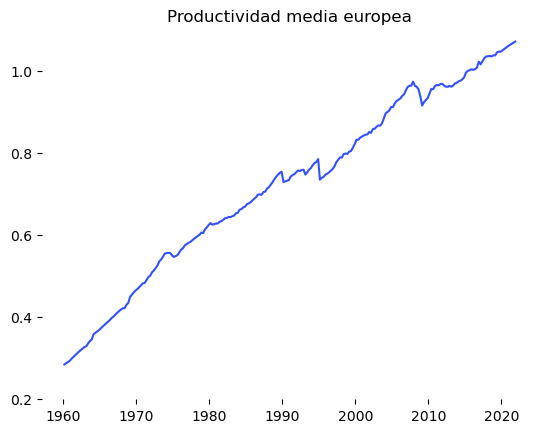

In [22]:
# Plot the data and set xticks
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO)
plt.yticks(plt.yticks()[0][::2])
plt.ylim(0.2, 1.1)
plt.box(False)
plt.title('Productividad media europea')

#plt.savefig('../Documento/imgs_desarrollo/serie_temporal_productividad')

plt.show()

La serie temporal presenta una clara tendencia ascendente sin muchas fluctuaciones. Cabe esperar que esto sea así, pues con el desarrollo de la tecnología a lo largo de los años, el trabajador cada vez es capaz de hacer más en menor tiempo.

## <a id = 'tspred'> Predicción de series temporales</a>

### <a id = 'ARIMA'>ARIMA </a>

##### Pasos para hacer un forecasting con ARIMA 


1) **Graficar la serie temporal** y empezar a sacar conclusiones de ella: ¿tiene tendencia? ¿tiene estacionalidad? ¿la varianza es constante a lo largo del tiempo? ¿es estacionaria?

<br>

2) Si la varianza no es constante a lo largo del tiempo, transformar la serie temporal aplicando la **transformación de** `Box-Cox`: el logaritmo. En el caso de esta serie temporal, como no toma (ni tomarán nunca, pues el valor más bajo de `Productividad` es $0$) valores negativos, se puede aplicar esta transformación sin problemas.

<br>

3) **Aplicar los test de ADF y KPSS** para determinar si la serie temporal es <u>estacionaria</u>.


- En caso de que no salga estacionaria:<br><br>
        
    - Si la serie temporal no es estacional (como parece ser el caso):<br><br>
    
        - Aplicar la diferencia de primer orden y pasar el test otra vez.<br><br>
        
        - Si vuelve a salir que no, aplicar la diferencia de segundo orden.<br><br>
        
Con esto debería ser suficiente para convertir una serie temporal no estacionaria en otra que sí lo sea.

<br>


4) Examinar los gráficos ***ACF*** y ***PACF*** y sacar conclusiones acerca de posibles modelos a emplear.

<br>

5) Creación y ajuste de modelos con las funciones `ARIMA` y `modelo.fit()` respectivamente.

<br>

6) Elegir el mejor modelo según su **AIC** y **BIC**. Se escogerá a aquel con *AIC* y *BIC* más bajos.


> **Nota**: Otras opciones que se pueden probar -y se van a probar- es utilizar librerías como `auto_arima`. Esta librería automatiza el proceso de elección de los parámetros $p, d$ y $q$  del modelo *ARIMA* a través de una búsqueda exhaustiva para encontrar los valores óptimos de cada parámetro.
  
<br>

7) Validación del modelo.

<br>

8) Realizar las predicciones.

###### Paso 1) Analizar la serie temporal

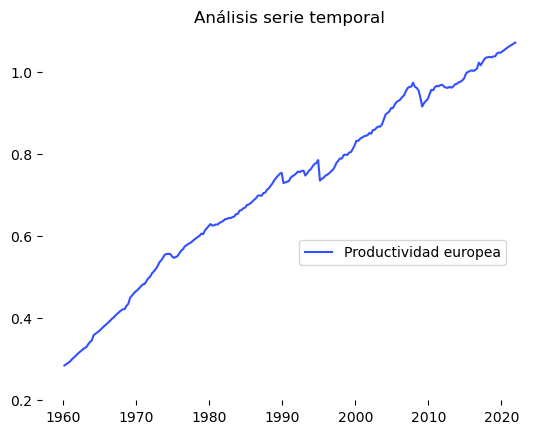

In [23]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO,
        label = 'Productividad europea')
plt.yticks(plt.yticks()[0][::2])
plt.ylim(0.2, 1.1)
plt.box(False)
plt.legend(loc = 'center right', bbox_to_anchor = (0.95, 0.4))
plt.title('Análisis serie temporal')
plt.show()

La serie temporal presenta una clara **tendencia ascendente**. Luego, seguramente sea necesario aplicarle como mínimo una diferencia para convertir esta serie en estacionaria. 

Por otro lado, la serie temporal no parece mostrar ningún patrón estacional. Por tanto, un modelo *ARIMA*  (y no *SARIMA*)\* probablemente sea el más apropiado. 

<br>

\* *SARIMA* es una <u>extensión</u> de ARIMA que está especializada en modelar series temporales con estacionalidad (**S**= <u>S</u>easonality).

###### Paso 2) Transformación Box-Cox

De momento, no parece que la serie temporal presente heterocedasticidad. Parece que la varianza se mantiene constante a lo largo del tiempo, pues no se aprecian picos de distinta amplitud a lo largo de la serie temporal (más allá de los picos de la propia tendencia). 


De todas maneras, si esto no fuera así, la función `ARIMA` lo indicaría en unas celdas después. 

###### Paso 3) Test ADF y KPSS

Con estos test, se va a tratar de ver si la serie temporal es, o no, estacionaria.

Se recuerda los contrastes de hipótesis de cada test:

**ADF**
- $H_0$: La serie temporal no es estacionaria.



- $H_A$: La serie temporal es estacionaria.

<br>

**KPSS**
- $H_0$: La serie temporal es estacionaria.



- $H_A$: La serie temporal no es estacionaria.

<br>

**Se decide establecer un $\alpha = 0.05$ para determinar si se rechaza la hipótesis nula o no.** Por tanto, si el $p\_valor < \alpha$, se rechazará la $H_0$.

In [24]:
ALPHA = 0.05
def adf_test(data, string):
    adf_resultado = adfuller(data)
    PVALOR = adf_resultado[1]
    print(f'{string}: {PVALOR:.3f}')
    if PVALOR < ALPHA:
        print('Se rechaza la hipótesis nula\n')
    else:
        print('No se rechaza la hipótesis nula\n')
    
def kpss_test(data, string):
    kpss_resultado = kpss(data, regression = 'c')
    PVALOR = kpss_resultado[1]
    print(f'{string}: {PVALOR:.3f}')
    if PVALOR < ALPHA:
        print('Se rechaza la hipótesis nula')
    else:
        print('No se rechaza la hipótesis nula')

In [25]:
adf_test(serie_temporal_productividad, "p_valor ADF sin la diferencia")
kpss_test(serie_temporal_productividad, "p_valor KPSS sin la diferencia")

p_valor ADF sin la diferencia: 0.313
No se rechaza la hipótesis nula

p_valor KPSS sin la diferencia: 0.010
Se rechaza la hipótesis nula


Luego, ambos test coinciden en que la serie temporal **no es estacionaria** y se debe aplicar, al menos, una diferencia.

In [26]:
ts_dif_productividad = serie_temporal_productividad.diff().fillna(method = 'bfill') #para rellenar el primer valor

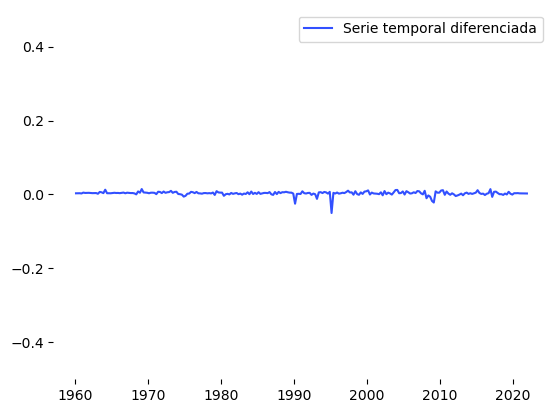

In [27]:
plt.plot(ts_dif_productividad, color = AZUL_OSCURO,
        label = 'Serie temporal diferenciada')
plt.ylim(-0.5, 0.5)
plt.box(False)
plt.legend(loc = 'upper right')

#plt.savefig('../Documento/imgs_desarrollo/ts_diff')

plt.show()

La serie temporal diferenciada seguramente sea, ahora ya sí, **estacionaria**. Esto es porque, a simple vista parece cumplir con todos los requisitos de una serie estacionaria: media constante, sin estacionalidad, sin heterocedasticidad y con una autocorrelación de cero. Cuando únicamente es la tendencia lo que lleva a una serie temporal a no ser estacionaria (como era el caso), normalmente una diferencia suele ser suficiente. De todas maneras, se vuelven a aplicar los test *ADF* y *KPSS* para corroborar si una diferencia es suficiente o no.

In [28]:
adf_test(ts_dif_productividad, "p_valor ADF sin la diferencia")
kpss_test(ts_dif_productividad, "p_valor KPSS sin la diferencia")

p_valor ADF sin la diferencia: 0.000
Se rechaza la hipótesis nula

p_valor KPSS sin la diferencia: 0.100
No se rechaza la hipótesis nula


Esta vez, tanto el test *ADF* como el test *KPSS*, coinciden en que la serie temporal ahora es **estacionaria**. Por tanto, se puede proceder al siguiente paso.

###### Paso 4) Gráficos ACF y PACF

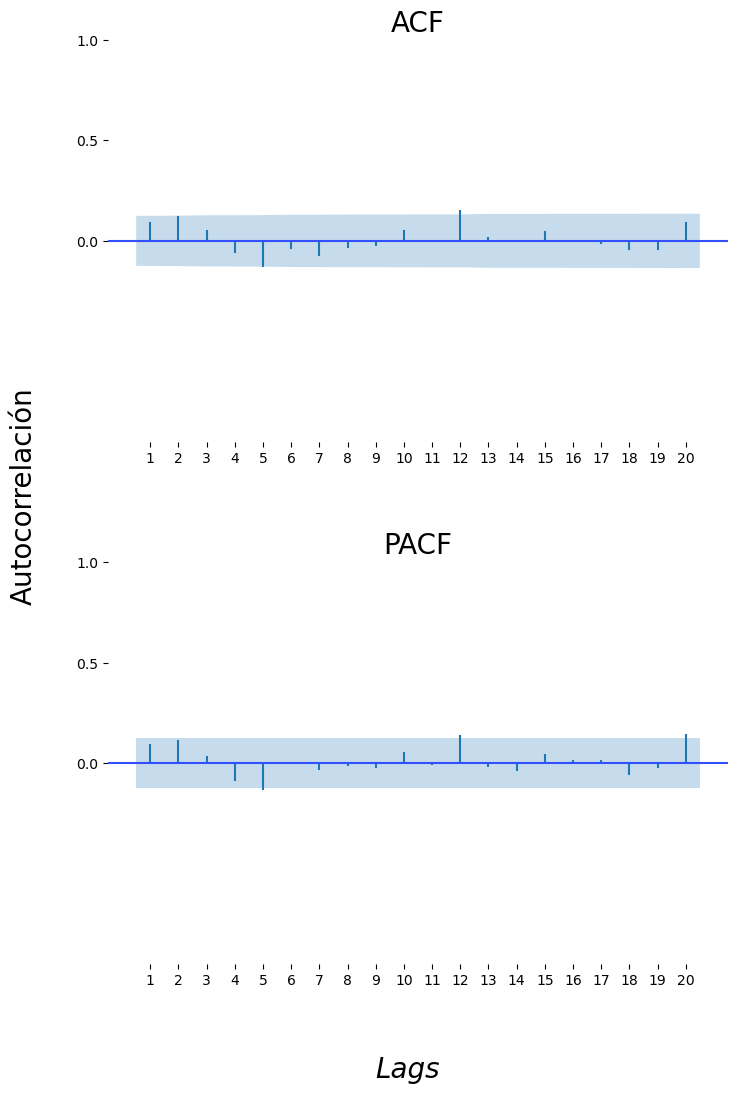

In [29]:
# ACF & PACF
XTICKS = np.arange(1,21)
YTICKS = [0, 0.5, 1]

fig, ax = plt.subplots(2,1, figsize=(8, 12), tight_layout = True,
                      gridspec_kw={'hspace': 0.3})

plot_acf(ts_dif_productividad, ax=ax[0], marker = None, lags = 20,
         zero = False, color = AZUL_OSCURO)
ax[0].set_title('ACF', fontsize=20)

plot_pacf(ts_dif_productividad, ax=ax[1], marker = None, lags = 20,
         zero = False, color = AZUL_OSCURO)
ax[1].set_title('PACF', fontsize=20)

for i  in range(0,2):
    ax[i].set_xticks(XTICKS)
    ax[i].set_yticks(YTICKS)
    ax[i].set_ylim(-1,1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
fig.supxlabel('Lags', ha='center', fontdict={'fontstyle': 'italic'}, 
              fontsize =20)
fig.supylabel('Autocorrelación',  ha='center', fontsize = 20)

fig.subplots_adjust(hspace=0.76)
plt.show()

Como se indicó en el estado de la cuestión, el gráfico *ACF* aporta varias informaciones:
- Si el algoritmo AR($p$) es viable para modelar esta serie temporal. O, en otras palabras, si el parámetro $p$ de ARIMA($p, d, q$) puede ser mayor que cero. Esto se sabe si el *ACF* presenta un patrón decreciente exponencialmente o un patrón sinusoidal. En este caso, presenta un **patrón sinusoidal**. Por tanto, es probable que $p > 0$.

- La otra información que aporta el *ACF* es el posible valor (o valores que van a estar en torno) de $q$. Para ello,  hay que fijarse en qué líneas verticales sobresalen la zona azul. En este caso, como posibles valores están el $2$ y el $5$ que son los únicos valores que está en límite  entre la zona azul y la zona blanca; pero sin llegar a sobrepasarla. Luego estos son los posibles valores que se tomarán del parámetro $q$.

<br>

Por otra parte, el gráfico *PACF* indica justo lo contrario. Es decir:
- Si el algoritmo MA($q$) es apropiado para modelar esta serie temporal. O, lo que es lo mismo, si el parámetro $q$ de ARIMA($p, d, q$) es mayor a cero. Esto ocurre si el *PACF* presenta un patrón decreciente exponencialmente o un patrón sinusoidal. En este caso, se vuelve a presentar un **patrón sinusoidal**. Luego, es probable que $q>0$.

- Por otra parte, el *PACF* es muy similar al *ACF* (no tiene por qué ser así). Vuelven a ser los *lags* $2$ (al límite) y  $5$ (sobresale un poco) los valores candidatos; esta vez del parámetro $p$.


En resumen, hay $4$ modelos *ARIMA* que se van a probar para modelar esta serie temporal. Recuérdese que esta serie temporal, sí ha hecho falta aplicarle una diferencia; por tanto,  el parámetro $d = 1$. Luego, los $4$ modelos *ARIMA* son:
- ARIMA ($2, 1, 2$)
- ARIMA ($2, 1, 5$)
- ARIMA ($5, 1, 2$)
- ARIMA ($5, 1, 5$)

> **Nota**: Información adicional como si la serie temporal presenta estacionalidad se puede vez también con estos  gráficos. Pero como se sabe que  la serie temporal es estacionaria (y por tanto, se sabe que no puede tener estacionalidad) no se ha visto necesario mencionarlo.

###### Paso 5) Creación y ajuste de modelos

Algo importante a recalcar en este punto, es que a la función `ARIMA` no se le pasa la serie temporal diferenciada. Ya lo hace por detrás esta función cuando se le indica que el parámetro $d = 1$ (en este caso). Diferenciar la serie temporal original, sin embargo, era necesario para poder determinar el correcto valor del parámetro $d$ y posteriormente los aproximados valores de $p$ y $q$ (pues el *ACF* y *PACF* se deben hacer sobre una serie temporal estacionaria).

In [30]:
modelos_arima= {'arima_2_1_2': ARIMA(serie_temporal_productividad, 
                                     order = (2,1,2)),
                 'arima_2_1_5': ARIMA(serie_temporal_productividad, 
                                      order = (2,1,5)),
                'arima_5_1_2': ARIMA(serie_temporal_productividad, 
                                     order = (5,1,2)),
                'arima_5_1_5': ARIMA(serie_temporal_productividad, 
                                     order = (5,1,5))}

In [31]:
for NOMBRE, MODELO in modelos_arima.items():
    print (f'CREANDO MODELO: {NOMBRE}')
    modelo_ajustado = MODELO.fit()
    # ahora en lugar de ser un diccionario con la declaración de los modelos
    # pasa a ser un dicionario con los modelos ajustados.
    modelos_arima[NOMBRE]= modelo_ajustado                                             
    print(modelo_ajustado.summary())
    print(type(modelo_ajustado))
    print('\n\n')

CREANDO MODELO: arima_2_1_2
                               SARIMAX Results                                
Dep. Variable:          Productividad   No. Observations:                  248
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 917.111
Date:                Tue, 09 Apr 2024   AIC                          -1824.222
Time:                        13:48:45   BIC                          -1806.675
Sample:                    03-01-1960   HQIC                         -1817.157
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.506      1.882      0.060      -0.040       1.945
ar.L2         -0.1674      0.444     -0.377      0.706      -1.038       0.703
ma.L1         -0.7645   

Al hacer `modelo.summary()`, se muestra información muy importante acerca del modelo. Lo que interesa para el siguiente paso es el `aic` y el `bic`.

###### Paso 6) Elegir al mejor modelo según su AIC y BIC

In [32]:
aic_min = np.inf

modelo_aic_min = None
for NOMBRE, MODELO in modelos_arima.items():
    print(str(NOMBRE) +': '+str(MODELO.aic))
    
    if MODELO.aic < aic_min:
        aic_min = MODELO.aic
        modelo_aic_min = str(NOMBRE)
        
mejor_modelo = modelos_arima[modelo_aic_min]
print("\n\n El modelo con el AIC más pequeño es el "+str(modelo_aic_min))

arima_2_1_2: -1824.2216901971856
arima_2_1_5: -1817.0089725024332
arima_5_1_2: -1819.6517684106211
arima_5_1_5: -1823.8257399043882


 El modelo con el AIC más pequeño es el arima_2_1_2


In [33]:
bic_min = np.inf

modelo_bic_min = None
for NOMBRE, MODELO in modelos_arima.items():
    print(str(NOMBRE) +': '+str(MODELO.bic))
    
    if MODELO.bic < bic_min:
        bic_min = MODELO.bic
        modelo_bic_min = str(NOMBRE)
        
mejor_modelo = modelos_arima[modelo_bic_min]
print("\n\n El modelo con el BIC más pequeño es el "+str(modelo_bic_min))

arima_2_1_2: -1806.6747485140456
arima_2_1_5: -1788.9338658094093
arima_5_1_2: -1791.5766617175973
arima_5_1_5: -1785.2224682014805


 El modelo con el BIC más pequeño es el arima_2_1_2


Tanto el valor `aic`, como el valor `bic` apuntan a que el mejor modelo de los $4$ propuestos, es el `arima_2_1_2`.

In [34]:
mejor_modelo = modelos_arima['arima_2_1_2']

##### Paso 7) Validación del modelo

Una vez elegido al  mejor modelo, hay que fijarse es en si la conclusión del `Paso 2` de no aplicar una transformación `Box-Cox` era correcta. Para ello, al hacer `model.summary`, hay una sección en donde se muestra el estadístico y el `p-valor` tras hacer el contraste de hipótesis conocido como `Breusch-Pagan`. Este contraste tiene las siguientes hipótesis:

- $H_0$: La serie temporal no presenta heterocedasticidad.

- $H_A$: La serie temporal presenta heterocedasticidad.

Véase la siguiente imagen.

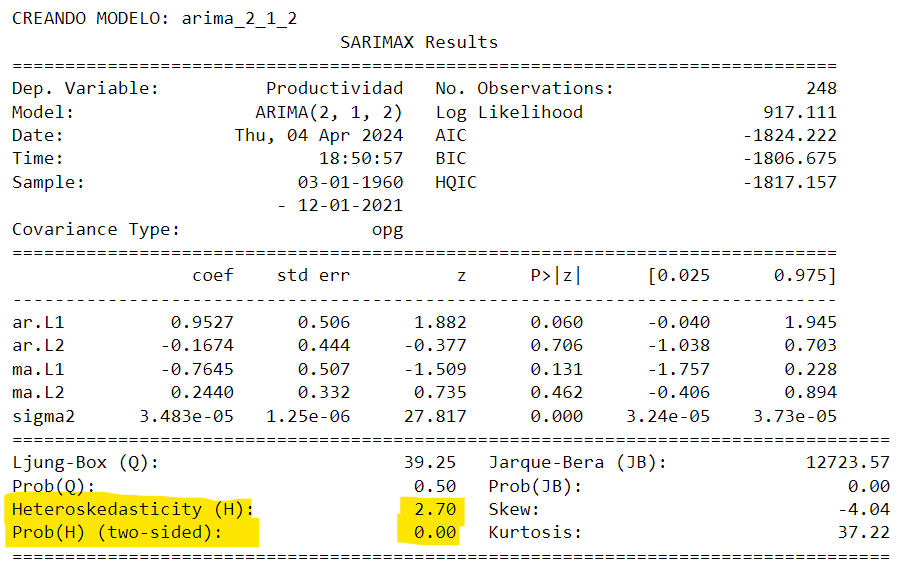

In [35]:
img = Image.open('img/heterok_test.png')
img.resize((30, 10))
display(img)

Luego, se rechaza la $H_0$, lo que quiere decir que a `serie_temporal_productividad` hay que aplicarle una transformación `Box-Cox` y volver a repetir el proceso hasta ahora.
<a id = 'boxcox'> </a>

Ademas, otro contraste útil para saber si es un modelo válido, es el `z-score`. El p-valor asociado a este contraste se encuentra en la segunda tabla, en la sección `P>|z|`.

In [36]:
mejor_modelo.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9527,0.506,1.882,0.060,-0.040,1.945
ar.L2,-0.1674,0.444,-0.377,0.706,-1.038,0.703
ma.L1,-0.7645,0.507,-1.509,0.131,-1.757,0.228
ma.L2,0.2440,0.332,0.735,0.462,-0.406,0.894
sigma2,3.483e-05,1.25e-06,27.817,0.000,3.24e-05,3.73e-05


O, mas directamente:

In [37]:
mejor_modelo.pvalues

ar.L1      5.989509e-02
ar.L2      7.061774e-01
ma.L1      1.312452e-01
ma.L2      4.621677e-01
sigma2    2.697052e-170
dtype: float64

Este contraste trata de verificar la significatividad de un coeficiente. La $H_0$ es que el coeficiente no es significativo y, por tanto, se debe eliminar del modelo. En este caso en concreto, al ser todos los p-valores > $0.05$, no se puede rechazar la hipótesis nula, indicando que **ningún coeficiente es significativo** y, por tanto, se debe buscar otro modelo mejor. 

Se procede pues, a eliminar la heterocedasticidad de `serie_temporal_productividad` con el fin de obtener un mejor modelo.

In [38]:
ts_log = np.log(serie_temporal_productividad)

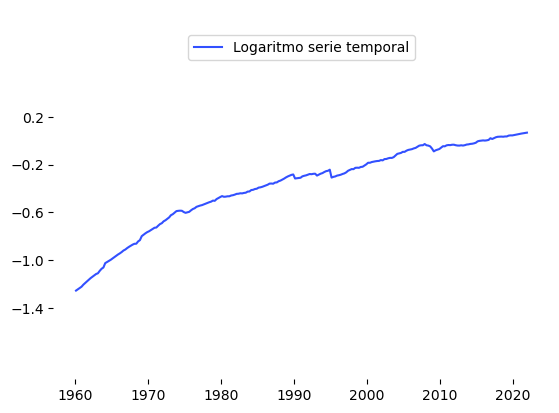

In [39]:
plt.plot(ts_log, color = AZUL_OSCURO)
plt.yticks(plt.yticks()[0][::2])
plt.ylim(-2, 1.1)
plt.box(False)
plt.legend(loc = 'upper center',  labels =['Logaritmo serie temporal'],
          bbox_to_anchor = (0.5, 0.95))

#plt.savefig('../Documento/imgs_desarrollo/ts_log')

plt.show()

> **Nota**: Aunque se forma sea muy parecida a la original, darse cuenta que el eje $y$ ha cambiado por completo.

<br>

Se va a ver ahora si hace falta diferenciar esta serie temporal.

In [40]:
adf_test(ts_log, "p_valor ADF sin la diferencia")
kpss_test(ts_log, "p_valor KPSS sin la diferencia")

p_valor ADF sin la diferencia: 0.000
Se rechaza la hipótesis nula

p_valor KPSS sin la diferencia: 0.010
Se rechaza la hipótesis nula


Como ambos valores discrepan, y la gráfica de arriba presenta tendencia, se decide *hacer caso* al test *KPSS* en lugar de al test *ADF* y hacer una diferencia a `ts_log`.

In [41]:
ts_log_diff = ts_log.diff()
ts_log_diff = ts_log_diff[1:]

> **Nota**: Esta última línea es necesaria para no tener en cuenta el primer valor de la diferencia, el cual es nulo debido a que el primer valor no tiene valores anteriores, y, por tanto, es incompatible con la fórmula de la diferencia.

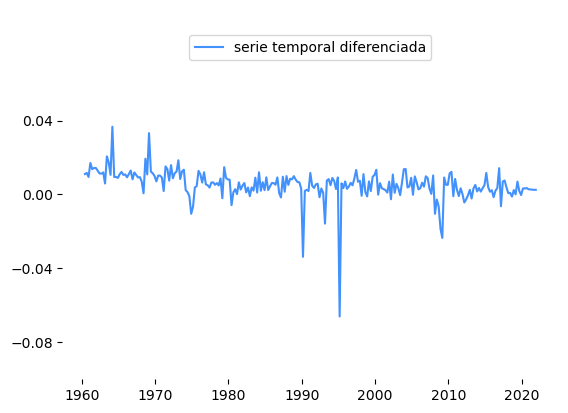

In [42]:
plt.plot(ts_log_diff, color = AZUL_TFG)
plt.yticks(plt.yticks()[0][::2])
plt.ylim(-0.1, 0.1)
plt.box(False)
plt.legend(loc = 'upper center',  labels =['serie temporal diferenciada'],
          bbox_to_anchor = (0.5, 0.95))

#plt.savefig('../Documento/imgs_desarrollo/ts_log_diff')

plt.show()

Ahora ya la serie temporal sí parece tener forma estacionaria.  Hay algunos picos, que aunque parezcan muy bruscos, hay que tener en cuenta que el eje $y$ contempla valores muy pequeños. Se vuelven a hacer ambos test: *ADF* y *KPSS*.

In [43]:
adf_test(ts_log_diff, "p_valor ADF sin la diferencia")
kpss_test(ts_log_diff, "p_valor KPSS sin la diferencia")

p_valor ADF sin la diferencia: 0.000
Se rechaza la hipótesis nula

p_valor KPSS sin la diferencia: 0.010
Se rechaza la hipótesis nula


Aunque ahora vuelvan a discrepar, debido a la forma de la serie temporal graficada recientemente, junto con el valor tan bajo que aporta el test *ADF*, se decide ahora *hacer caso* al test *ADF* y no diferenciarla más. 

<br>

Se pasan a hacer los gráficos *ACF* y *PACF*.

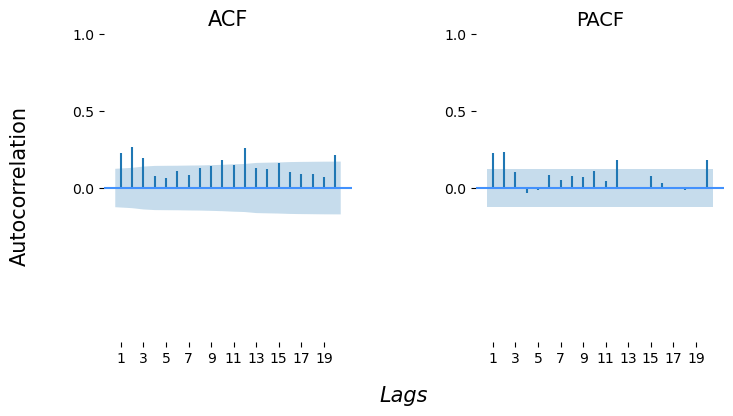

In [44]:
XTICKS = np.arange(1, 21)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, gridspec_kw={'wspace': 0.5})

plot_acf(ts_log_diff, ax=ax[0], marker=None, lags=20, zero=False, color=AZUL_TFG)
ax[0].set_title('ACF', fontsize=15)
ax[0].set_xticks(XTICKS[::2]) 

plot_pacf(ts_log_diff, ax=ax[1], marker=None, lags=20, zero=False, title='PACF', color=AZUL_TFG)
ax[1].set_title('PACF', fontsize=14)
ax[1].set_xticks(XTICKS[::2]) 

for i in range(0, 2):
    ax[i].set_yticks(YTICKS)
    ax[i].set_ylim(-1, 1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

xlabel = fig.supxlabel('Lags', ha='center', fontdict={'fontstyle': 'italic'}, fontsize=15)
xlabel.set_position((0.5, -0.05)) 
xlabel.set_fontsize(15)
fig.supylabel('Autocorrelation', ha='center', fontsize=15)

#plt.savefig('../Documento/imgs_desarrollo/acf_pacf')

plt.show()

Siguiendo la misma lógica de antes para elegir parámetros, estos gráficos muestran lo siguiente:

***ACF***
- No presenta un patrón claro (ni decreciente exponencialmente, ni sinusoidal) y tampoco decrece a cero rápidamente. No se puede extraer información concluyente con respecto a si el valor de $p$ pueda ser ---seguramente--- mayor a cero. Esto se determinará con ayuda del PACF.
- $1, 2$ y $3$ como posibles valores de $q$.

***PACF***
- Patrón ligeramente sinusoidal. Luego, seguramente $q$ sea mayor a cero.
- $1$ y $2$ como posibles valores de $p$.

<br>

Con esta información, se van a probar los siguientes modelos *ARIMA*:
- ARIMA ($1, 1, 1$)
- ARIMA ($1, 1, 2$)
- ARIMA ($1, 1, 3$)
- ARIMA ($2, 1, 1$)
- ARIMA ($2, 1, 2$)
- ARIMA ($2, 1, 3$)

>**Nota**: Ahora, hay que pasar `ts_log` a la función `ARIMA`. Posteriormente, habrá que transformar (invertir) las predicciones para obtener `serie_temporal_productividad`.

<a id = 'arima'></a>

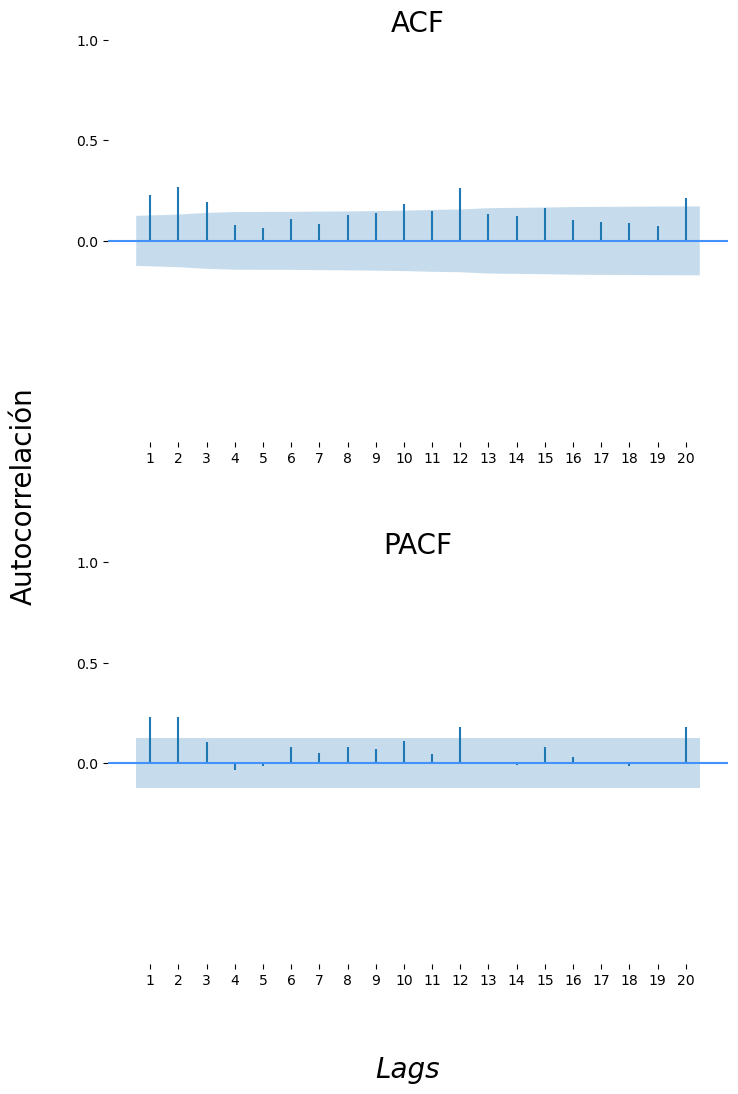

In [45]:
# ACF & PACF
XTICKS = np.arange(1,21)
YTICKS = [0, 0.5, 1]

fig, ax = plt.subplots(2,1, figsize=(8, 12), tight_layout = True,
                      gridspec_kw={'hspace': 0.3})

plot_acf(ts_log_diff, ax=ax[0], marker = None, lags = 20,
         zero = False, color = AZUL_TFG)
ax[0].set_title('ACF', fontsize=20)
plot_pacf(ts_log_diff, ax=ax[1], marker = None, lags = 20,
         zero = False, title = 'PACF', color = AZUL_TFG)
ax[1].set_title('PACF', fontsize=20)

for i  in range(0,2):
    ax[i].set_xticks(XTICKS)
    ax[i].set_yticks(YTICKS)
    ax[i].set_ylim(-1,1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
fig.supxlabel('Lags', ha='center', fontdict={'fontstyle': 'italic'}, 
              fontsize =20)
fig.supylabel('Autocorrelación',  ha='center', fontsize = 20)

fig.subplots_adjust(hspace=0.76)

#plt.savefig('../Documento/imgs_desarrollo/acf_pacf')

plt.show()

In [46]:
modelos_arima= {'arima_1_1_1': ARIMA(ts_log, 
                                    order = (1,1,1)),
                'arima_1_1_2': ARIMA(ts_log, 
                                    order = (1,1,2)),
                'arima_1_1_3': ARIMA(ts_log, 
                                    order = (1,1,3)),
                'arima_2_1_1': ARIMA(ts_log, 
                                    order = (2,1,1)),
                'arima_2_1_2': ARIMA(ts_log, 
                                    order = (2,1,2)),
                'arima_2_1_3': ARIMA(ts_log, 
                                    order = (2,1,3))
               }

In [47]:
for NOMBRE, MODELO in modelos_arima.items():
    print (f'CREANDO MODELO: {NOMBRE}')
    modelo_ajustado = MODELO.fit()
    # ahora en lugar de ser un diccionario con la declaración de los modelos
    # pasa a ser un dicionario con los modelos ajustados.
    modelos_arima[NOMBRE]= modelo_ajustado                                             
    print(modelo_ajustado.summary())
    print(type(modelo_ajustado))
    print('\n\n')

CREANDO MODELO: arima_1_1_1
                               SARIMAX Results                                
Dep. Variable:          Productividad   No. Observations:                  248
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 844.701
Date:                Tue, 09 Apr 2024   AIC                          -1683.401
Time:                        13:48:51   BIC                          -1672.873
Sample:                    03-01-1960   HQIC                         -1679.162
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.026     36.765      0.000       0.913       1.015
ma.L1         -0.7376      0.045    -16.234      0.000      -0.827      -0.649
sigma2      6.237e-05   

                               SARIMAX Results                                
Dep. Variable:          Productividad   No. Observations:                  248
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 847.828
Date:                Tue, 09 Apr 2024   AIC                          -1683.655
Time:                        13:48:52   BIC                          -1662.599
Sample:                    03-01-1960   HQIC                         -1675.178
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3043      0.737      0.413      0.680      -1.140       1.749
ar.L2          0.6685      0.723      0.924      0.355      -0.749       2.086
ma.L1         -0.2424      0.735     -0.330      0.7

Al igual que antes, se mira qué modelo es el mejor respecto de los valores de los criterios `aic` y `bic`.

In [48]:
aic_min = np.inf

modelo_aic_min = None
for NOMBRE, MODELO in modelos_arima.items():
    print(str(NOMBRE) +': '+str(MODELO.aic))
    
    if MODELO.aic < aic_min:
        aic_min = MODELO.aic
        modelo_aic_min = str(NOMBRE)
        
mejor_modelo = modelos_arima[modelo_aic_min]
print("\n\n El modelo con el AIC más pequeño es el "+str(modelo_aic_min))

arima_1_1_1: -1683.40121404613
arima_1_1_2: -1673.8353633302731
arima_1_1_3: -1678.6598814285321
arima_2_1_1: -1676.239966433718
arima_2_1_2: -1673.8668615638023
arima_2_1_3: -1683.6552348152272


 El modelo con el AIC más pequeño es el arima_2_1_3


In [49]:
bic_min = np.inf

modelo_bic_min = None
for NOMBRE, MODELO in modelos_arima.items():
    print(str(NOMBRE) +': '+str(MODELO.bic))
    
    if MODELO.bic < bic_min:
        bic_min = MODELO.bic
        modelo_bic_min = str(NOMBRE)
        
mejor_modelo = modelos_arima[modelo_bic_min]
print("\n\n El modelo con el BIC más pequeño es el "+str(modelo_bic_min))

arima_1_1_1: -1672.8730490362461
arima_1_1_2: -1659.7978099837612
arima_1_1_3: -1661.1129397453922
arima_2_1_1: -1662.2024130872062
arima_2_1_2: -1656.3199198806624
arima_2_1_3: -1662.5989047954595


 El modelo con el BIC más pequeño es el arima_1_1_1


Aunque el *AIC* y el *BIC* discrepen en qué modelo es el mejor, si es cierto que el ***BIC*** entre el modelo `arima_1_1_1` y el modelo `arima_2_1_3` **es una diferencia mucho mayor** que su diferencia entre sus respectivos valores *AIC*.

In [50]:
aic_1_1_1 = modelos_arima['arima_1_1_1'].aic
bic_2_1_3 = modelos_arima['arima_2_1_3'].bic
DIF_AIC = abs(aic_1_1_1 - aic_min)
DIF_BIC = abs(bic_2_1_3 - bic_min)

print(f'La diferencia entre los AIC de los dos (aparentemente) mejores'\
     f' modelos  es de'\
     f' \033[1m{DIF_AIC:.2f}\033[0m. Mientras que la diferencia entre'\
     f' los BIC de los dos modelos es de \033[1m{DIF_BIC:.2f}\033[0m.')

La diferencia entre los AIC de los dos (aparentemente) mejores modelos  es de 0.25. Mientras que la diferencia entre los BIC de los dos modelos es de 10.27.


En otras palabras, se elige al `arima_1_1_1` como mejor modelo por tener un valor *AIC* muy parecido al `arima_2_1_3` y tener un *BIC* bastante más bajo que `arima_2_1_3`.

Ahora, como bien se ha recalcado en el estado de la cuestión, los valores de los parámetros elegidos han sido por los gráficos *ACF* y *PACF*. Mientras estos valores no aseguran que estos sean los mejores modelos, sí aseguran que sean **valores aproximados**. Como en el caso de este trabajo, se quieren realizar las predicciones lo más precisas posibles, se va a aplicar <u>adicionalmente</u> la librería `auto_arima()`, la cual, a través de una búsqueda exhaustiva, obtiene el mejor modelo *ARIMA* posible para la serie temporal dada.

Según la [documentación](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html), `auto_arima()` funciona de la siguiente manera:
> `auto_arima()` works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, `d`, and then fitting models within ranges of defined `start_p`, `max_p`, `start_q`, `max_q` ranges. If the `seasonal` optional is enabled, auto-ARIMA also seeks to identify the optimal `P` and `Q` hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, `D`.<br><br>
In order to find the best model, auto-ARIMA optimizes for a given `information_criterion`, one of `(‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)` (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

En la siguiente celda, se está especificando a `auto_arima()` que pruebe con todas las posibles combinaciones $p$ y  $q$ con rangos: 
- $1 \leq p \leq 5 $
- $1 \leq q \leq 5.$

> **Nota**: $d$ se establece a $1$ porque `auto_arima()` es una función de la librería `pmdarima`. Esta librería es distinta a la empleada hasta ahora, la cual es `statsmodels`. La librería `pmdarima`, aunque tenga su propio test *ADF*, arroja distintos resultados que el de `statsmodels`. Por tanto, como el parámetro $d$ se determinó que iba a ser $1$, se especifica así para que el mejor modelo de la librería `pmdarima` sea algo consistente con la librería `statsmodels`.

Alguna información adicional se le añade como: qué criterio emplear para encontrar el mejor modelo y qué contraste de hipótesis utilizar para determinar la estacionariedad de la serie temporal.

Todo esto con el fin de encontrar el mejor modelo ARIMA($p,d,q$) posible.

In [51]:
modelo_auto_arima = auto_arima(ts_log, start_p = 1, d = 1,
                                start_q = 1, max_p = 5, max_q = 5,
                                seasonal = False, stationary = False,
                                information_criterion = 'aic',
                                alpha = 0.05, scoring = 'mae',
                                suppess_warnings = True)

In [52]:
print(modelo_auto_arima)

 ARIMA(1,1,1)(0,0,0)[0] intercept


In [53]:
modelo_auto_arima = auto_arima(ts_log, start_p = 1, d = 1,
                                start_q = 1, max_p = 5, max_q = 5,
                                seasonal = False, stationary = False,
                                information_criterion = 'bic',
                                alpha = 0.05, scoring = 'mae',
                                suppess_warnings = True)

In [54]:
print(modelo_auto_arima)

 ARIMA(1,1,1)(0,0,0)[0] intercept


Como se decía, la función `auto_arima()`, al ser de un módulo distinto, difiere en algunos resultados respecto del módulo `statsmodels`. En este caso, proporciona como mejor modelo ARIMA($1,1,1$) teniendo en cuenta tanto el criterio *AIC*, como el criterio *BIC* (recuédese que `statsmodels` había seleccionado al modelo ARIMA($2,1,3$) como modelo con menor *AIC*.

In [55]:
mejor_modelo = modelos_arima['arima_1_1_1']

###### Paso 7) Validación del modelo (continuación)

Se procede a hacer lo mismo que antes: `model.summary()` y ver si, al haber aplicado la transformación `box-cox`, se ha conseguido que el `p-valor` del contraste de hipótesis para la heterocedasticidad sea > $0,05$.

In [56]:
mejor_modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Productividad   No. Observations:                  248
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 844.701
Date:                Tue, 09 Apr 2024   AIC                          -1683.401
Time:                        13:49:01   BIC                          -1672.873
Sample:                    03-01-1960   HQIC                         -1679.162
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.026     36.765      0.000       0.913       1.015
ma.L1         -0.7376      0.045    -16.234      0.000      -0.827      -0.649
sigma2      6.237e-05   1.65e-06     37.774      0.000    5.91e-05    6.56e-05
===================================================================================
Ljung-Box (Q):                       42.98   Jarque-Bera (JB):              9365.44
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -3.41
Prob(H) (two-sided):                  0.50   Kurtosis:                        32.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ahora ya sí `Prob(H)` $= 0.50 > 0.05$. Por tanto, **no** se rechaza la $H_0$ y se puede aceptar que la serie temporal no presenta heterocedasticidad. El `p-valor` del contraste de hipótesis de `Breusch-Pagan` se puede ver de manera más rigurosa en  la siguiente celda.

In [57]:
p_valor_BP = mejor_modelo.test_heteroskedasticity(method = 'breakvar')[0][1]
print(f'El p-valor del contraste de hipótesis de Breusch-Pagan es: {p_valor_BP:.3f}')

El p-valor del contraste de hipótesis de Breusch-Pagan es: 0.501


Para seguir validando el modelo, y verificar que es un modelo adecuado, los **residuos** del modelo son <u>muy importantes</u>. Estos residuos deberán ser **ruido**. Esto quiere decir que el modelo ha sido capaz de obtener (casi) toda la información de la serie temporal original y, por tanto, es un buen modelo. 

Para poder comprobar que los residuos se pueden considerar ruido, deben seguir una distribución normal con media cero (definición de ruido) y además no debe haber autocorrelación entre ellos. 

Primero se va a ver esto recientemente mencionado gráficamente, y posteriormente con contrastes de hipótesis.

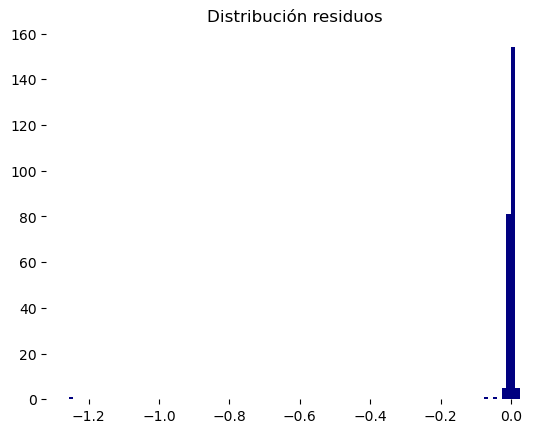

In [58]:
plt.hist(mejor_modelo.resid, bins = 100, color = 'navy')
plt.box(False)
plt.title('Distribución residuos')
plt.show()

El *outlier* seguramente se deba al valor del primer residuo.

In [59]:
mejor_modelo.resid[0]

-1.256095780326188

Efectivamente, es el valor del primer residuo. *ARIMA*, se recuerda que es una composición de los algoritmos AR($p$) y MA($q$). Ambos emplean valores o errores, respectivamente, del pasado para modelar el valor presente. **El primer residuo de todos, al no tener información pasada, es normal que siempre sea alto** y por ello, una práctica común es no tenerlo en cuenta para los contrastes de hipótesis.

In [60]:
residuos = mejor_modelo.resid.to_frame(name = 'Values')
residuos

,Values
1960-03-01,-1.256096
1960-06-01,0.011050
1960-09-01,0.005730
1960-12-01,0.001694
1961-03-01,0.009036
...,...
2020-12-01,0.000472
2021-03-01,0.000313
2021-06-01,0.000249
2021-09-01,0.000177


<a id ='distres'> </a>

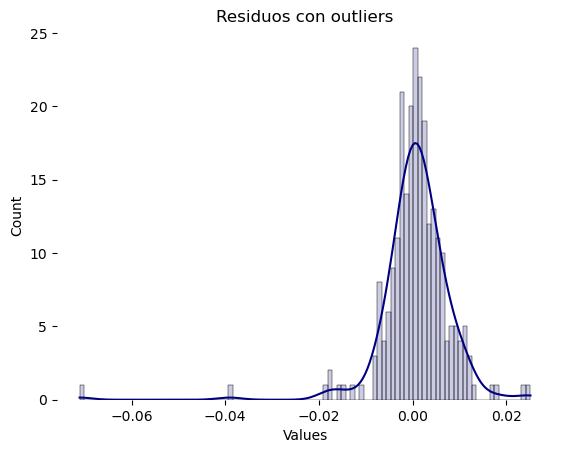

In [61]:
residuos_limpios = residuos.iloc[1:,:]
sns.histplot(data = residuos_limpios, x = 'Values', kde = True, bins = 100, color = 'navy',
            alpha = 0.2)


plt.box(False)
plt.title('Residuos con outliers')
#plt.savefig('../Documento/imgs_desarrollo/dist_res')

Tiene una distribución muy parecida a una  distribución normal, de no ser por unos pocos *outliers*. Se verá posteriormente con el contraste de hipótesis si estos *outliers* dan problemas o no.

Lo siguiente que se va a comprobar gráficamente, son los residuos en sí, y ver si parece haber (a primera vista) alguna correlación entre ellos. Esto se puede ver fácilmente si hay alguna tendencia o estacionalidad. Es decir, algún patrón; o, más matemáticamente: algún **componente determinístico**.

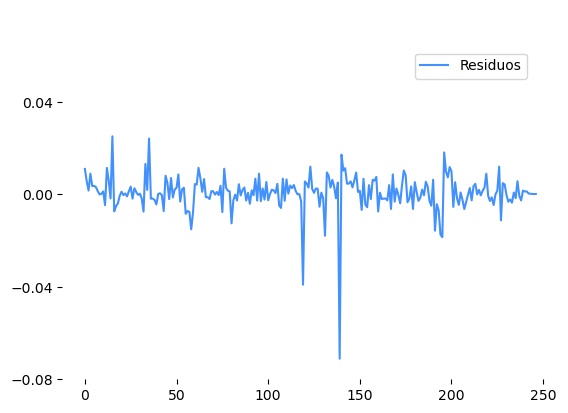

In [62]:
plt.plot(np.arange(0, len(residuos_limpios['Values'].to_list())), residuos_limpios['Values'].to_list(),
        color = AZUL_TFG, label = 'Residuos')
plt.yticks(plt.yticks()[0][::2])
plt.ylim(-0.08, 0.08)
plt.box(False)
plt.legend(loc = 'upper right', bbox_to_anchor = (0.95, 0.9))

#plt.savefig('../Documento/imgs_desarrollo/res_autocorr1')

plt.show()

Tiene forma de serie estacionaria. Es decir, no parece que haya correlación entre los residuos. Al igual que antes, aunque parezca que hay un pico muy grande, hay que tener en cuenta los valores tan pequeños en el  eje $y$. Véase la siguiente gráfica en donde los valores del eje $y$ son modificados (a unos valores que tampoco son altos).

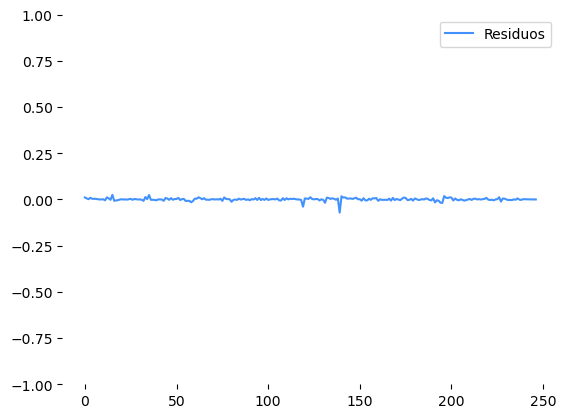

In [63]:
plt.plot(np.arange(0, len(residuos_limpios['Values'].to_list())), residuos_limpios['Values'].to_list(),
        color = AZUL_TFG, label = 'Residuos')
plt.ylim(-1, 1)
plt.box(False)
plt.legend(loc = 'upper right')
plt.show()

Ahora ya el pico no parece tan grande. 

In [64]:
adf_test(residuos_limpios, "p_valor ADF sin la diferencia")

p_valor ADF sin la diferencia: 0.000
Se rechaza la hipótesis nula



Incluso se puede ver que el test *ADF* marca los residuos como serie no estacionaria con muchísima confianza (un `p-valor` muy bajo). 

<br>

Otra manera muy común de ver los residuos, es con un `scatterplot`.

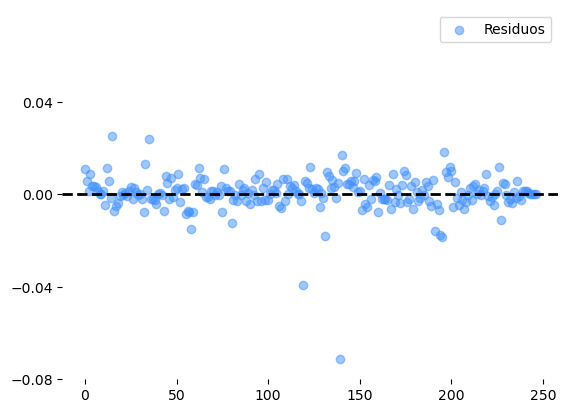

In [65]:
plt.scatter(np.arange(0, len(residuos_limpios['Values'].to_list())), residuos_limpios['Values'].to_list(),
           color = AZUL_TFG, alpha = 0.5, label = 'Residuos')
plt.axhline(y=0, color='black', ls='--', lw = 2)
plt.yticks(plt.yticks()[0][::2])
plt.ylim(-0.08, 0.08)
plt.box(False)
plt.legend(loc = 'upper right')

#plt.savefig('../Documento/imgs_desarrollo/res_autocorr2')

plt.show()

Parece que están todos distribuidos en torno a cero. 

Todos los gráficos parecen indicar que se trata de un buen modelo y que se podrían hacer predicciones con él. Sin embargo, la última palabra la tienen los contrastes de hipótesis. 

Se empieza por ver esto último graficado: si los residuos están (o no) autocorrelados. Para ello, se va a emplear el test `Ljung-box`. Este test mide la correlación  entre un residuo y los *lags* anteriores. Este número de *lags* suele ser un número representativo de la serie temporal. Es decir, si la serie temporal tiene estacionalidad cada $12$ periodos, entonces `lags = 12`. Esta serie temporal, al tener datos trimestrales durante varios años, un posible candidato sería `lags = 4` (pues hay 4  trimestres al año).

Las hipótesis del test `Ljung-box` son las siguientes:

- $H_0$: El residuo $r_t$ y $r_{t-l}$ no están correlados.

- $H_A$: El residuo $r_t$ y $r_{t-l}$ están correlados.

>**Nota**: La función `test_serial_correlation` se encarga de obtener los residuos del modelo. 

In [66]:
P_VALORES_LJUNG_BOX = mejor_modelo.test_serial_correlation(method = 'ljungbox', lags = 4)[0][1]
print(f'Los p-valores de los primeros 4 lags son lo siguientes:')

Los p-valores de los primeros 4 lags son lo siguientes:


In [67]:
for P_VALOR in P_VALORES_LJUNG_BOX:
    print(f'{P_VALOR}\n')

0.33904774881490174

0.5213695920235728

0.6923360886099952

0.14707749799546904



Se puede ver que ninguno de los `p-valores` mostrados es menor a $0.05$. Se puede hacer un pequeño código para ver esto de manera algo más rigurosa.

In [68]:
se_rechaza_h_nula = False
ALPHA = 0.05
for P_VALOR in P_VALORES_LJUNG_BOX:
    if P_VALOR < ALPHA:
        se_rechaza_h_nula = True
        
if se_rechaza_h_nula:
    print('Se rechaza la hipótesis nula del test Ljung-Box.')
else:
    print('No se rechaza la hipótesis nula del test Ljung-Box.')

No se rechaza la hipótesis nula del test Ljung-Box.


Respecto al contraste de hipótesis sobre si los residuos siguen una distribución gaussiana, seguramente salga que no  debido a los *outliers*, los cuales provocan una asimetría en el histograma, como se vio anteriormente [aquí](#distres). Para verificar esto, hay múltiples contrastes de hipótesis conocidos como *tests de normalidad*. El que se va a emplear, por ser el que emplea la función `ARIMA`, se llama `Jarque-Bera`. Las hipótesis de este contraste son las siguientes:

- $H_0$: Los residuos siguen una distribución normal.

- $H_A$: Los residuos no siguen una distribución normal.


In [69]:
P_VALOR_JB = mejor_modelo.test_normality(method = 'jarquebera')[0][1]
ALPHA = 0.05

if P_VALOR_JB < ALPHA:
    print('Se rechaza la hipótesis nula del test Jarque-Bera.')
else:
    print('No se rechaza la hipótesis nula del test Jarque-Bera.')

Se rechaza la hipótesis nula del test Jarque-Bera.


Como bien se estimaba, el test iba a salir a que no se podía aceptar que los residuos estuvieran distribuidos de manera normal debido a los *outliers*.

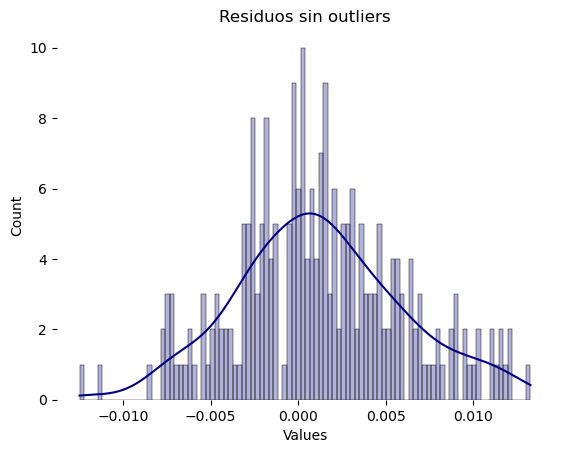

In [70]:
res_values = residuos_limpios['Values']
res_values_sin_outliers = residuos_limpios[(res_values > -0.015) & (res_values < 0.015)]
sns.histplot(data = res_values_sin_outliers, x = 'Values', kde = True, bins = 100, color = 'navy',
            alpha = 0.3)

plt.box(False)
plt.title('Residuos sin outliers')
#plt.savefig('../Documento/imgs_desarrollo/dist_res_limpios')

Ahora, pese a que el apuntamiento (*kurtosis*) podría ser mejor ya parece una distribución normal eliminando unos pocos *outliers*. Se deja en la siguiente celda el número de *outliers* eliminados.

In [71]:
num_res_orig = len(residuos_limpios)
num_res_sin_outliers = len(res_values_sin_outliers)
prct_res = (num_res_sin_outliers * 100)/ num_res_orig
print(f'De los {num_res_orig} residuos originales, se han mantenido {num_res_sin_outliers}.'\
     f' Es decir, se han conservado un \033[1m{prct_res:.2f}%\033[0m de los residuos')

De los 247 residuos originales, se han mantenido 236. Es decir, se han conservado un 95.55% de los residuos


Se vuelve a pasar, habiendo hecho una pequeña transformación en los residuos, el test `Jarque-Bera`, el cual, aunque no se haya mencionado hasta ahora, tiene en cuenta la asimetría y el apuntamiento de la distribución para obtener su estadístico.

In [72]:
P_VALOR_JB = sm.stats.stattools.jarque_bera(res_values_sin_outliers)[1][0]
if P_VALOR_JB < ALPHA:
    print(f'Se rechaza la hipótesis nula del test Jarque-Bera.'\
         f' P-VALOR_JB: {P_VALOR_JB:.3f}')
else:
    print('No se rechaza la hipótesis nula del test Jarque-Bera.'\
    f' P-VALOR_JB: {P_VALOR_JB:.3f}')

No se rechaza la hipótesis nula del test Jarque-Bera. P-VALOR_JB: 0.627


Luego, **se puede considerar que** `arima_1_1_1` **es un buen modelo**, pues ha pasado todo los test de validación. Se procede a hacer predicciones con él.

###### Paso 8) Predicciones con ARIMA

Antes que nada, se empieza por ver cómo el modelo elegido para esta serie temporal: `arima_1_1_1`. Se trata de un modelo que combina AR($1$) y MA($1$). Se deja la fórmula de este modelo por si se entiende esto mejor matemáticamente:

$$ \text{ARIMA}(1,1,1) = c + \phi y_{t-1} + \epsilon_t - \theta \epsilon_{t-1}$$

- En donde:
    - $c$ es una constante estimada por el modelo.
    - $\phi$ el parámetro AR($1$) estimado por el modelo.
    - $\theta$ parámetro MA($1$) estimado por el modelo.
    - $y_{t-1}$ es el valor de la serie temporal en el periodo anterior.
    - $\epsilon_t, \epsilon_{t-1}$ y error del ajuste actual y previo respectivamente por el modelo.
    
    
Estos valores se pueden ver al hacer `modelo.summary().tables[1]`, en la sección de `coef`.

In [73]:
mejor_modelo.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9640,0.026,36.765,0.000,0.913,1.015
ma.L1,-0.7376,0.045,-16.234,0.000,-0.827,-0.649
sigma2,6.237e-05,1.65e-06,37.774,0.000,5.91e-05,6.56e-05


De manera más directa se puede hacer lo siguiente:

In [74]:
mejor_modelo.params

ar.L1     0.963974
ma.L1    -0.737566
sigma2    0.000062
dtype: float64

En el print de arriba:
- `ar.L1` $\rightarrow$ $\phi$
- `ma.L1` $\rightarrow$ $\theta$
- `sigma2` indica error cuadrático medio del modelo, en donde $\epsilon_t$ y $\epsilon_{t-1}$ están implícitamente. 

> **Nota**: - `const` $\rightarrow$ $c$ si no aparece en los parámetros es porque su valor es cero.


Además, cada uno de estos coeficientes tiene un grado de significatividad (como se mencionó con anterioridad). Esto se mide a través de un contraste de hipótesis `z-score` y, se recuerda  que su $H_0$ es  que el coeficiente no es significativo para el modelo y, por tanto, se puede (debe) eliminar del modelo. 

El `p-valor` asociado a cada coeficiente, se puede ver también al hacer `model.summary()`, en la columa `P>|z|`; o, de manera más directa con `modelo.pvalues`. 

In [75]:
mejor_modelo.pvalues

ar.L1     6.585343e-296
ma.L1      2.898283e-59
sigma2     0.000000e+00
dtype: float64

En todos, este valor es < $0.05$ (y por bastante), lo que indica que **todos los coeficientes en este modelo en concreto son significativos**.

Luego, este modelo ha pasado los $4$ contrastes de hipótesis y, por tanto, se elige como modelo para realizar las  predicciones.

Ahora ya sí que sí, se procede a realizar las predicciones con *ARIMA*.

Para realizar las predicciones en *ARIMA*, hay dos funciones a tener en cuenta: `predict()` y `forecast()`. 
- El primero, `predict()` sirve para dos cosas:

    1) Ver cómo ajusta el modelo a la serie temporal dada.
    
    2) Realizar predicciones a futuro.
    
    
- El segundo, `forecast()`, sirve únicamente para realizar predicciones a futuro. Se puede ver como que `predict()` es una extensión de `forecast()`.

Adicionalmente, se empleará el método `get_forecast()` para obtener unos intervalos de confianza en la predicción.

<br>

Dicho  esto, para ver cómo el modelo se ajusta a la serie temporal, se ha de usar el método `predict()` como  se acaba de mencionar.

In [76]:
inicio_ajuste = serie_temporal_productividad.index.min()
final_ajuste = serie_temporal_productividad.index.max()
ajuste_modelo = mejor_modelo.predict(start=inicio_ajuste, end=final_ajuste)
ajuste_modelo

1960-03-01    0.000000
1960-06-01   -1.256096
1960-09-01   -1.239120
1960-12-01   -1.225595
1961-03-01   -1.215888
                ...   
2020-12-01    0.057680
2021-03-01    0.060549
2021-06-01    0.063243
2021-09-01    0.065844
2021-12-01    0.068329
Freq: QS-DEC, Length: 248, dtype: float64

Los valores de ajuste no se parecen en nada a los de `serie_temporal_productividad`. Tienen valores negativos y todo. Si se recuerda, [aquí](#boxcox) se aplicó una transformación `logarítmica` a la serie temporal; y posteriormente, se pasó esta transformación al modelo *ARIMA* ([aquí](#arima)). Esto quiere decir que, para obtener el ajuste y las predicciones reales, va a haber que realizar la operación inversa al `logaritmo`: la `exponencial`. Esto se hace de manera muy sencilla con el comando `np.exp`.

In [77]:
modelo_arima = np.exp(ajuste_modelo)
modelo_arima # Ahora ya sí el output tiene más sentido

1960-03-01    1.000000
1960-06-01    0.284764
1960-09-01    0.289639
1960-12-01    0.293583
1961-03-01    0.296447
                ...   
2020-12-01    1.059376
2021-03-01    1.062420
2021-06-01    1.065286
2021-09-01    1.068060
2021-12-01    1.070717
Freq: QS-DEC, Length: 248, dtype: float64

Únicamente, hay que tener una cosa más en cuenta: de la misma manera que se ha mencionado antes ([aquí](#res)), es común eliminar el primer valor del residuo. Esto ocurre cuando a una serie temporal se le aplica una diferencia en el estudio, la diferencia hace que el primer valor se pierda**\***. Luego, el modelo *ARIMA*, cuando se diferencia, empieza a ajustar bien a partir del segundo valor.


**\***Pues el primer valor es incompatible con la fórmula de la diferencia porque no hay valor anterior al primero.

In [78]:
modelo_arima = modelo_arima[1:]

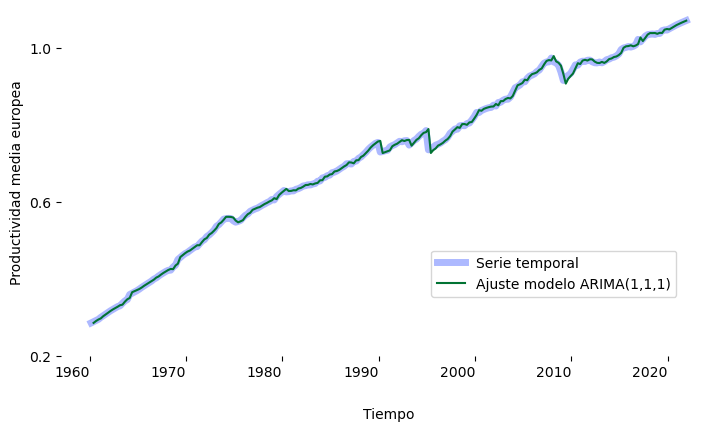

In [79]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 5)
modelo_arima.plot(color = TRAIN_color, label = 'Ajuste modelo ARIMA(1,1,1)')
plt.ylim(0.2, 1.1)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) #labelpad para espaciado
plt.ylabel ('Productividad media europea')
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.95, 0.15))
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/ajuste_arima', bbox_inches='tight')

plt.show()

En la gráfica se puede ver cómo el modelo ajusta de manera bastante precisa a la serie temporal. No se puede definir si el modelo esta sobreajustado, porque pese a que ajusta muy bien la recta, se trata de un modelo simple, y es el mejor encontrado por `auto_arima()` a través de la métrica de *AIC*, que penaliza modelos muy complejos, y, por tanto, suele seleccionar modelos que no generen *overfitting*. 

Para hacer la predicción a futuro, aunque se puede utilizar la función `prediction()`, se va a utilizar `forecast()` que únicamente hace predicción a futuro. Se ha considerado conveniente realizar una predicción a futuro de $8$ periodos, i.e. $8$ trimestres o dos años; como se quiera ver.

In [80]:
forecast_8_periodos = mejor_modelo.forecast(steps =  8)
forecast_8_periodos

2022-03-01    0.070832
2022-06-01    0.073026
2022-09-01    0.075141
2022-12-01    0.077179
2023-03-01    0.079144
2023-06-01    0.081039
2023-09-01    0.082865
2023-12-01    0.084625
Freq: QS-DEC, dtype: float64

Al igual que pasó con el ajuste, la predicción también hay que transformarla con `np.exp`.

In [81]:
forecast_8_periodos_real = np.exp(forecast_8_periodos)
forecast_8_periodos_real

2022-03-01    1.073401
2022-06-01    1.075758
2022-09-01    1.078036
2022-12-01    1.080236
2023-03-01    1.082360
2023-06-01    1.084413
2023-09-01    1.086395
2023-12-01    1.088309
Freq: QS-DEC, dtype: float64

Para que la predicción sea continua con respecto a la serie temporal, se añade al principio de las predicciones el último valor de `serie_temporal_productividad`.

In [82]:
ultimo_valor = serie_temporal_productividad.iloc[-1]
ultimo_valor = pd.Series(ultimo_valor.values, 
                           index = [serie_temporal_productividad.index.max()])
ultimo_valor

2021-12-01    1.070961
dtype: float64

In [83]:
forecast_8_periodos_real = ultimo_valor.append(forecast_8_periodos_real)
forecast_8_periodos_real

2021-12-01    1.070961
2022-03-01    1.073401
2022-06-01    1.075758
2022-09-01    1.078036
2022-12-01    1.080236
2023-03-01    1.082360
2023-06-01    1.084413
2023-09-01    1.086395
2023-12-01    1.088309
dtype: float64

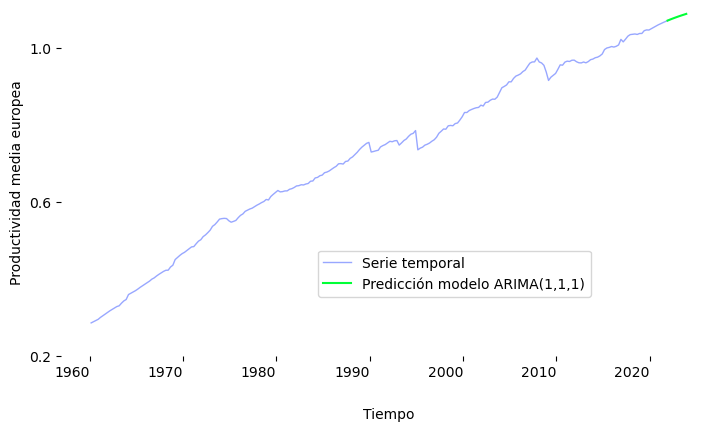

In [84]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.5, lw = 1)
forecast_8_periodos_real.plot(color = ARIMA_color, label = 'Predicción modelo ARIMA(1,1,1)')
plt.ylim(0.2, 1.1)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.ylabel ('Productividad media europea')
plt.box(False)
plt.legend(loc = 'lower center', bbox_to_anchor = (0.6, 0.15))

#plt.savefig('../Documento/imgs_desarrollo/pred_arima')

plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas
plt.show()

Por último, es muy común graficar un **intervalo de confianza** (normalmente del $95\%$ de confianza) junto con la predicción. Para ello, es necesario usar el método `get_forecast()`.

In [85]:
np.exp(mejor_modelo.get_forecast(steps = 8).conf_int())

,lower Productividad,upper Productividad
2022-03-01,1.056915,1.090145
2022-06-01,1.049730,1.102433
2022-09-01,1.042869,1.114388
2022-12-01,1.035902,1.126467
2023-03-01,1.028725,1.138792
2023-06-01,1.021319,1.151404
2023-09-01,1.013695,1.164308
2023-12-01,1.005874,1.177499


In [86]:
conf_intervals = np.exp(mejor_modelo.get_forecast(steps = 8).conf_int())
ci_inferior = conf_intervals.iloc[:, 0]
ci_superior = conf_intervals.iloc[:, 1]

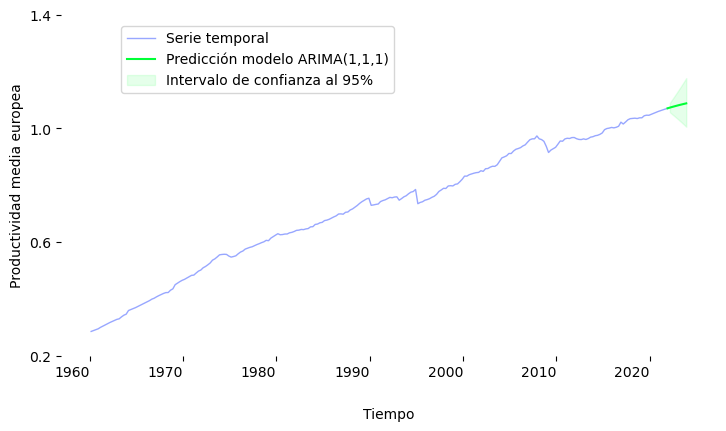

In [87]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.5, lw = 1)
forecast_8_periodos_real.plot(color = ARIMA_color, 
                              label = 'Predicción modelo ARIMA(1,1,1)')
plt.fill_between(conf_intervals.index, ci_inferior , ci_superior, 
                 color=ARIMA_color, alpha=0.1, 
                 label='Intervalo de confianza al 95%')
plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.ylabel ('Productividad media europea')
plt.box(False)
plt.legend(loc = 'lower center', bbox_to_anchor = (0.3, 0.75))

plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas
plt.show()

### <a id = 'lstm'> LSTM (Long Short-Term Memory) </a>

Korstanje, en su libro, *Advanced Forecasting with Python*, dice lo siguiente:

> *“The LSTM cell adds long-term memory in an even more performant way because it allows even more parameters to be learned. This makes it the most powerful Recurrent Neural Network to do forecasting, especially when you have a longer-term trend in your data. **LSTMs are one of the state-of-the-art models for forecasting at the moment**,” (2021)*.

Las redes neuronales es un tema complejo y con muchos conceptos que no se han explicado en el estado de la cuestión porque van más allá del contenido de este  trabajo. Se aprovechará este notebook para ir explicando, según se vayan necesitando, algunos conceptos básicos a la hora de ir creando el modelo. 

Lo más común a la hora de realizar una predicción con redes neuronales es tener una o varias columnas `features` que sirvan como *input* (variables independientes, denominadas comúnmente con la letra $X$), y una columna `target` (variable dependiente denominada comúnmente con la letra $y$) que sirva como *output*. En este caso particular no va a ser así. En este caso, se va a utilizar `TimeseriesGenerator` para realizar las predicciones. Funciona algo parecido a como funciona el algoritmo AR($p$), y para generar datos futuros, se empleará información de datos pasados. En otras palabras, los datos de entrada y salida serán de la misma columna: `Productividad` en este caso. En celdas más adelante se explica con algo más de detalle `TimeseriesGenerator`.
    
Los pasos que se van a seguir a continuación son los siguientes:
- Normalización de los datos.
- División de datos en *train* y *test*.
- Formateo de los datos.
- Definición de una arquitectura de red.
- Definición del optimizador, función de pérdida y métricas de monitorización con la función `compile()`.
- Ajustar el modelo con la función `fit()`. Aquí se especificarán las `epochs` y el `batch_size`.
- Evaluación del modelo.
- Validación del modelo.
- Predicción.

Para estos pasos, se utilizará principalmente el módulo de `Keras`, que es el módulo de redes neuronales integrado sobre una biblioteca mayor para inteligencia artificial llamada `Tensorflow`.

##### Normalización de los datos

La normalización de los datos, no es un paso necesario, pero si muy recomendable, pues facilita el entrenamiento de la red neuronal. Para ello, se va a emplear la función `MinMaxScaler` de la librería `Sklearn`.

In [88]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(serie_temporal_productividad)
scaled_data = min_max_scaler.transform(serie_temporal_productividad)

##### División de datos en Train y Test

Se va a emplear una división estándar (hay varias) para *train* y *test*: $80\%$ de los datos para *train* y el $20\%$ restante para *test*.

Para ello se va a  utilizar la función `train_test_split` del módulo de `Sklearn`. 

> **Nota**: Normalmente, esta división se hace de manera aleatoria. Como en este problema en concreto, se está trabajando con una serie temporal, en donde el orden de los datos importa, y mucho, se establece el parámetro `shuffle = False` para que esta división entre *train* y *test* sea ordenada: primeros $80\%$ de los datos para *train* y los $20\%$ últimos datos para *test*.

In [89]:
train_lstm, test_lstm = train_test_split(scaled_data,  
                                    test_size =0.2, shuffle = False)

In [90]:
print(f'Datos train: {len(train_lstm)}')

Datos train: 198


In [91]:
train_lstm_df = pd.DataFrame(train_lstm)
train_lstm_df

,0
0,0.000000
1,0.004024
2,0.008318
3,0.011851
4,0.018283
...,...
193,0.859791
194,0.851950
195,0.829653
196,0.801969


In [92]:
print(f'Datos test: {len(test_lstm)}')

Datos test: 50


In [93]:
test_lstm_df = pd.DataFrame(test_lstm)
test_lstm_df

,0
0,0.818907
1,0.825090
2,0.838729
3,0.853526
4,0.852384
5,0.862605
6,0.865718
7,0.864652
8,0.868772
9,0.869062


<a id = 'train'></a>

##### Formateo de los datos

Ahora hay que decidir cuántos datos pasados se van a utilizar para realizar las predicciones. Como la serie temporal presenta una clara tendencia, es indicativo de que seguramente valores próximos sean muy importantes para predecir el valor futuro. Por ello se ha decidido usar rango pequeño de posibles valores. La elección se realizará de manera **empírica**.

<a id = 'gen'></a>

In [94]:
BATCH_SIZE = 1
num_datos_pasados = 3
train_generator = TimeseriesGenerator(data=train_lstm, 
                                      targets=train_lstm, 
                                      length=num_datos_pasados, 
                                      batch_size=BATCH_SIZE)

test_generator = TimeseriesGenerator(data=test_lstm, 
                                     targets=test_lstm, 
                                     length=num_datos_pasados, 
                                     batch_size=BATCH_SIZE)

Los datos de entrada de la capa `LSTM`, hay que modificarlos.  Esto es porque la `LSTM` (del módulo `Keras`) espera un vector de 3 dimensiones: `(batch_size, timesteps, features)`, o, equivalentemente, `(num_samples, timesteps, channels)`. Esto lo hace directamente `TimeseriesGenerator`. Para entender mejor qué está almacenando la variable `generator` en la celda anterior, véase el siguiente código.

In [95]:
lstm_input = serie_temporal_productividad.head(num_datos_pasados)
lstm_input

,Productividad
1960-03-01,0.284764
1960-06-01,0.287928
1960-09-01,0.291303


In [96]:
lstm_output = serie_temporal_productividad.iloc[15:16]
lstm_output

,Productividad
1963-12-01,0.345595


In [97]:
datos_pasados, valor_a_predecir = train_generator[0]
print(f'Con estos datos: \n {min_max_scaler.inverse_transform(datos_pasados[0])}')
print(f'\nSe va a tratar de predecir el siguiente valor: \n'\
      f'{min_max_scaler.inverse_transform(valor_a_predecir)[0][0]}')

Con estos datos: 
 [[0.28476364]
 [0.28792767]
 [0.29130327]]

Se va a tratar de predecir el siguiente valor: 
0.29408074937098083


En realidad, esto sería con los datos normalizados.

> **Nota**: De la misma manera que se ha hecho en la última celda, va a haber que transformar los datos de predicción para *desnormalizarlos* con la función `min_max_scaler.inverse_transform`. 

En la siguiente celda se puede comprobar cómo `TimeseriesGenerator` transforma los datos en la tupla `(batch_size, timesteps, channels)`. 

In [98]:
datos_pasados.shape

(1, 3, 1)

`batch_size`, la primera de las tres dimensiones, se le ha indicado como parámetro en `TimeseriesGenerator`. `timesteps` lo mismo (en `lenght`). `timesteps` indica cuántos datos del pasado se van a emplear para realizar predicciones futuras. Una vez entendido `timesteps` se puede entender mejor `batch_size`, el cual indica, cuántos lotes de datos pasados se van a emplear. En este caso 1. La última dimensión, `channels` er igual a $1$ porque se trata de una serie temporal **univariante**. 

##### Arquitectura LSTM

Como se mencionó en el estado de la cuestión, una red de este tipo tiene 3 capas a diferenciar:
- **Capa de entrada**. Implícita en `input_shape (num_datos_pasados,CHANNELS)`. Este parámetro recibe `(timesteps, channels)` de la tupla `(batch_size, timesteps, channels)` que se ha visto recientemente. 


- **Capas ocultas** (`LSTM`). La elección de neuronas en cada capa oculta y el número de capas ocultas óptimo se debe hacer a prueba y error; no hay un número mínimo y tampoco máximo. Cuantos más datos se tengan, más variables de entrada y más complejo sea el problema, más compleja deberá ser la red  neuronal. Esto se traduce en que más capas ocultas y con más neuronas deberá haber. En el caso de este trabajo, se ha decidido por empezar por arquitecturas sencillas e ir aumentando la complejidad de estas hasta encontrar un buen modelo. <br>Una regla no escrita es que el número de neuronas en cada capa oculta deberá ser una potencia de dos, y a medida que se avanza en cada capa, disminuir la potencia en uno. Dicho esto, la elección de capas ocultas, y de número de neuronas por cada capa oculta **ha sido decidido de manera empírica**.


- **Capa de salida**(`Dense`). El número de neuronas que hay en esta capa varía según el problema que se quiera conseguir con la red neuronal. En el caso de este trabajo, como la predicción es sobre una serie temporal (y no una clasificación u otros tipos de predicción), **deberá haber una única neurona**. La función de activación, se elige la más simple `linear` (y es la de por defecto). La teoría indica que `relu` debería ser más apropiada proque `Productividad` no puede tomar valores negativos, pero en las pruebas de modelo se ha visto un mejor rendimiento con `activation = linear`.

Además, como el modelo generado es secuencial (una capa detrás de otra) se utilizará la función de Keras `Sequential()`. Adicionalmente, se aplicará entre capa y capa, `batchNormalization` y `Dropout`. El primero normaliza los *outputs* de las neuronas entre capa y capa, mejorando y haciendo más eficiente el entrenamiento de la red neuronal. El segundo es una medida de regularización desactivando neuronas con cierta probabilidad en la capa asignada.

In [99]:
CHANNELS = 1
modelo_LSTM = Sequential()


modelo_LSTM.add(LSTM(64, activation = 'tanh', # funciones de la LSTM
                     recurrent_activation = 'sigmoid',
                     input_shape = (num_datos_pasados,CHANNELS),
                     return_sequences=True)) # return_sequences=True por no ser la última capa
modelo_LSTM.add(Dropout(0.2))
modelo_LSTM.add(BatchNormalization())

modelo_LSTM.add(LSTM(32, activation = 'tanh', # funciones de la LSTM
                     recurrent_activation = 'sigmoid',
                     input_shape = (num_datos_pasados,CHANNELS))) 
modelo_LSTM.add(Dropout(0.2))
modelo_LSTM.add(BatchNormalization())


modelo_LSTM.add(Dense(1, activation = 'linear')) #una capa de salida porque es un problema de forecasting

In [100]:
modelo_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 batch_normalization (BatchN  (None, 3, 64)            256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

##### Definición de la función de pérdida y optimizador 

En este paso se define cómo va a aprender y mejorar la red neuronal. Para esto, se utiliza la función `compile()`. Se emplea la función de pérdida `mean_squared_error` por su popularidad en este tipo de problemas y el optimizador `Adam` por ser uno de los mejores optimizadores junto con `rmsprop` y otros. Adicionalmente, se establece un `learning_rate` estándar (uno de los estándares). Esto indica en qué medida el optimizador, `Adam` en este caso, modifica  los  pesos cada `batch_size`.

In [101]:
optimizer = Adam(learning_rate=0.1)
modelo_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)

##### Ajuste del modelo

En este paso es donde el modelo empieza a entrenarse con la función `fit()`. No hace falta definir aquí (se hace normalmente) el `batch_size`, pues ya ha sido definido antes. Este parámetro indica cada cuántos datos de entrenamiento se actualizan los pesos de la red neuronal. Adicionalmente, se define otro parámetro muy importante: `epochs`. Este parámetro indica cuántas veces la red neuronal se va a entrenar con el conjunto de datos de entrenamiento. Una metáfora podría ser la siguiente:
>*`batch_size`, si una persona estudia, se podría ver como cada cuántas páginas del libro la persona se testea a sí misma y aprende. `epoch` sería las veces que esa persona se estudia el libro*.

En este caso en concreto, como el `batch_size = 1` y `num_datos_pasados = 3`  y hay $198$ datos de *train* (se vio [aquí](#train)), hay $195$ batches por epoch. Esto es porque al ser el `batch_size = 1`, se va entrenando dato por dato, de uno en uno. Es decir, el primer batch será \[$0$, ... , $2$\]; el segundo \[$1$, ... , $3$\],  etc. Si el `batch_size` fuera igual a dos, habría la mitad de batches, i.e. $98$, pues la secuencia que antes se ha dividido en dos pasos, se haría en uno sólo. La razón por la que hay $195$ batches, es cada uno contiene $3$ datos (especificado en la variable `num_datos_pasados` [aquí](#gen)). Entonces pues, el batch número $195$, contendría los datos del $196$ al $198$ que ya es el máximo de datos en *train*.

Se establece `epoch = 100` porque es un estándar.

Por último se añade `early_stopping`. Esto es muy útil para varias cosas:
- Evitar que el modelo sobreentrene.
- Evita que el modelo que se genere al final del entrenamiento acabe teniendo un error mayor del que debe. 
- Evitar entrenamiento innecesario.

Esto lo consigue gracias al parámetro `patience`. A este parámetro se le asigna un valor entero $\beta$. Esto indica que si pasadas $\beta$ épocas, la función de pérdida (`loss`) no ha mejorado, se para el entrenamiento. Entrenar de más una red neuronal puede terminar generando modelos con mayores errores, ya sea por sobreentramiento, o porque mayores épocas y  mejor precisión no es una correlación directa del $100\%$.

Por último y muy importante a la hora de haber encontrado el mejor modelo posible, es la  utilización de `ModelCheckpoint` para guardar el mejor modelo generado en el entrenamiento.

In [102]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               mode='auto', 
                               verbose=2)

model_checkpoint = ModelCheckpoint('modelos_LSTM/prueba.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   mode='auto', 
                                   verbose=1)

modelo_entrenado_LSTM = modelo_LSTM.fit(train_generator, 
                           epochs=100,
                           verbose=1, 
                           callbacks=[early_stopping, model_checkpoint], 
                           validation_data=test_generator)

Epoch 1/100
192/195 [============================>.] - ETA: 0s - loss: 0.0829
Epoch 1: val_loss improved from inf to 0.21505, saving model to modelos_LSTM\prueba.h5
195/195 [==============================] - 14s 23ms/step - loss: 0.0830 - val_loss: 0.2151
Epoch 2/100
193/195 [============================>.] - ETA: 0s - loss: 0.0693
Epoch 2: val_loss did not improve from 0.21505
195/195 [==============================] - 3s 13ms/step - loss: 0.0707 - val_loss: 0.3034
Epoch 3/100
191/195 [============================>.] - ETA: 0s - loss: 0.0791
Epoch 3: val_loss did not improve from 0.21505
195/195 [==============================] - 2s 12ms/step - loss: 0.0788 - val_loss: 0.4099
Epoch 4/100
193/195 [============================>.] - ETA: 0s - loss: 0.1386
Epoch 4: val_loss did not improve from 0.21505
195/195 [==============================] - 2s 12ms/step - loss: 0.1372 - val_loss: 3.2435
Epoch 5/100
193/195 [============================>.] - ETA: 0s - loss: 0.0657
Epoch 5: val_loss imp

In [103]:
mejor_modelo_LSTM = load_model('modelos_LSTM/prueba.h5')

<h3 style = color:red>ATENCIÓN</h3>

**Descomentar la siguiente línea de código para utilizar el modelo empleado en este TFG. Este modelo ha sido el mejor que se ha podido encontrar después de +100 modelos. Cabe recalcar que este modelo ha sido obtenido con la misma configuración que hay en este código**.

In [104]:
# mejor_modelo_LSTM = load_model('modelos_LSTM/modelo_tfg.h5')

##### Monitorización del modelo

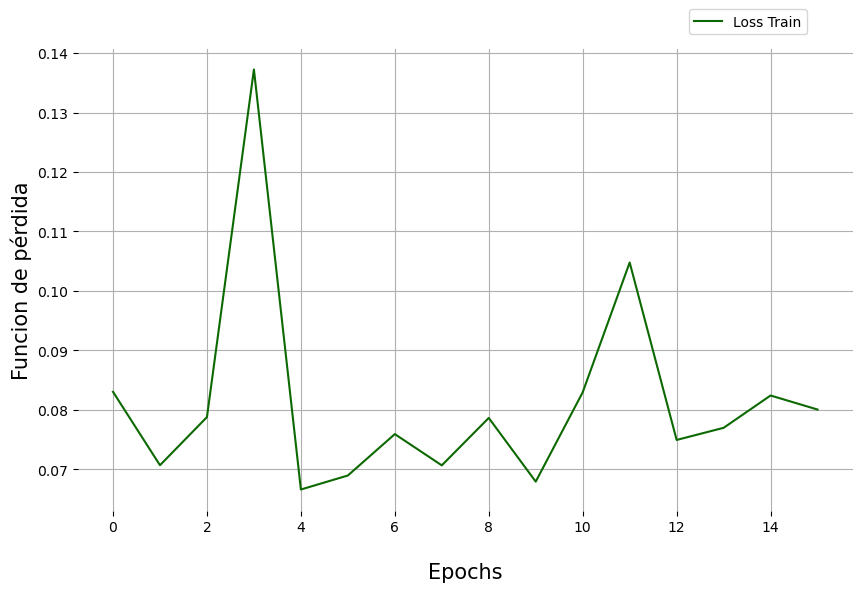

In [105]:
metric_train = np.array(modelo_entrenado_LSTM.history['loss'])

plt.figure(figsize=(10, 6))
plt.plot(metric_train, label='Loss Train', 
         color = (12/255, 105/255, 1/255))

plt.xlabel('Epochs', fontsize = 15, labelpad = 20)
plt.ylabel('Funcion de pérdida', fontsize = 15)
plt.grid()
plt.box(False)
plt.legend(loc='upper right', bbox_to_anchor = (0.95, 1.1))

##### Validación del modelo

In [106]:
y_train_lstm = mejor_modelo_LSTM.predict(train_generator)
y_test_lstm = mejor_modelo_LSTM.predict(test_generator)

47/47 [==============================] - 0s 5ms/step


Como se ha especificado antes, va a ser necesario *desnormalizar* los datos para ver su predicción real.

In [107]:
y_train_lstm = min_max_scaler.inverse_transform(y_train_lstm.reshape(-1, 1))
y_test_lstm = min_max_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

Ahora ya se puede calcular el *MAE (Mean Absolute Error)*.

In [108]:
mae_train_lstm = mean_absolute_error(y_true=train_lstm[num_datos_pasados:], y_pred=y_train_lstm)
mae_test_lstm = mean_absolute_error(y_true=test_lstm[num_datos_pasados:], y_pred=y_test_lstm)
print(f'\nMAE - Train: {mae_train_lstm}')
print(f'MAE - Test:  {mae_test_lstm}')


MAE - Train: 0.2579558602405435
MAE - Test:  0.11008531895082901


En el siguiente código, se va a crear un *dataframe* con los valores predichos por el modelo en el conjunto de `train_lstm`. El `-1` es debido a que los índices empiezan en $0$ y no en $1$.

In [109]:
primer_train_index = num_datos_pasados -1
ultimo_train_index = len(train_lstm) -1
train_index = serie_temporal_productividad.iloc[primer_train_index:ultimo_train_index,:].index
train_pred = pd.DataFrame({'Values': y_train_lstm.flatten()}, index = train_index)

In [110]:
primer_test_index = len(serie_temporal_productividad) - len(y_test_lstm) -1
ultimo_test_index = len(serie_temporal_productividad) -1
test_index = serie_temporal_productividad.iloc[primer_test_index:ultimo_test_index,:].index
test_pred = pd.DataFrame({'Values': y_test_lstm.flatten()}, index = test_index)

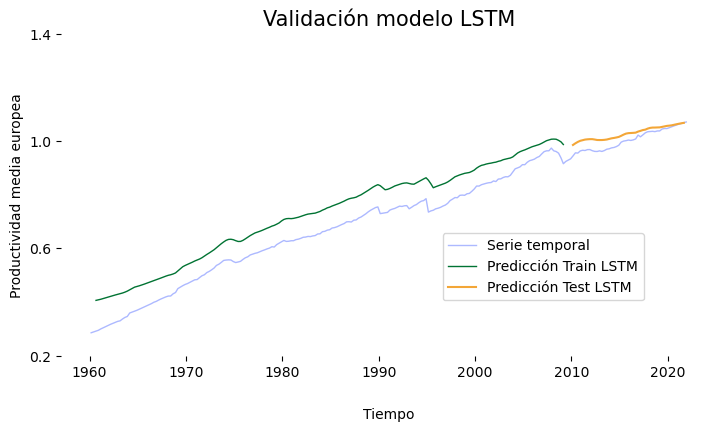

In [111]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

plt.plot(train_pred, color = TRAIN_color, 
         label = 'Predicción Train LSTM', lw = 1)

plt.plot(test_pred, color = TEST_color,
        label = 'Predicción Test LSTM')

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.ylabel ('Productividad media europea')
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Validación modelo LSTM', 
          fontsize = 15)
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/ajuste_lstm', bbox_inches='tight')

plt.show()

En esta  gráfica se puede ver muy bien por qué el *MAE* en el conjunto de *test* sale mucho menor que el *MAE* del conjunto de *train*: se ajusta mucho mejor a sus respectivot datos `serie_temporal_productividad`. Parece que el conjunto de *train*, la forma la tiene (casi) perfecta, simplemente que sobreestima un poco de más los valores.


> **Nota**: El hueco de en medio se debe a que como se utilizan $3$ valores para poder predecir el futuro (`num_datos_pasado`), esos primeros datos en *test* no tienen predicción. Pasa lo mismo en *train* que empieza un poco después que `serie_temporal_productividad`.

##### Predicciones LSTM

Como se dijo anteriormente, se van a utilizar los últimos $3$ datos para predecir el dato $4$. Para poder predecir varios datos en el futuro, estos $f$ datos se deben ir actualizándose. Es decir:
- $[1, \cdots, 3] \Rightarrow 4$


- $ \quad \text{Se actualiza} $


- $[2, \cdots, 4] \Rightarrow 5$


- $ \quad \text{Se actualiza}$


- $[3, \cdots, 5] \Rightarrow 6$
- $ \hspace{1cm} \vdots$

In [112]:
predicciones = []

primera_prediccion = test_lstm[-num_datos_pasados:]
ultimos_15_datos = primera_prediccion.reshape((BATCH_SIZE, num_datos_pasados, CHANNELS))
dias_a_predecir = 8

for DIA in range(0, dias_a_predecir):
    
    prediccion_normalizada = mejor_modelo_LSTM.predict(ultimos_15_datos)[0]
    prediccion_desnormalizada = min_max_scaler.inverse_transform(prediccion_normalizada.reshape(-1, 1))
    prediccion_desnormalizada = prediccion_desnormalizada.reshape((BATCH_SIZE, 1, CHANNELS))

    predicciones.append(prediccion_desnormalizada[0][0][0])
    
    ultimos_15_datos = np.append(ultimos_15_datos[:,1:,:], [[prediccion_normalizada]], axis=1)

1/1 [==============================] - 0s 49ms/step


In [113]:
predicciones

[1.0692184,
 1.0699979,
 1.0703152,
 1.0701826,
 1.070377,
 1.070446,
 1.0704705,
 1.0705267]

Una vez establecidas las fechas  sobre las que se va a predecir, se va a añadir a `predicciones` el último dato  de `Productividad` (`serie_temporal_productividad.loc[-1,0]`), al inicio de  las predicciones, para que las predicciones sean continuas con respecto a la serie temporal.

In [114]:
dia_primera_prediccion = serie_temporal_productividad.index.max()
dia_ultima_prediccion = datetime(2023, 12, 31)
dates = pd.date_range(start = dia_primera_prediccion,
                     end = dia_ultima_prediccion, freq = 'Q')

In [115]:
predicciones.insert(0, serie_temporal_productividad.iloc[-1, 0])
predicciones_lstm = pd.DataFrame({'prediccion': predicciones}, 
                                index = dates)
predicciones_lstm

,prediccion
2021-12-31,1.070961
2022-03-31,1.069218
2022-06-30,1.069998
2022-09-30,1.070315
2022-12-31,1.070183
2023-03-31,1.070377
2023-06-30,1.070446
2023-09-30,1.070470
2023-12-31,1.070527


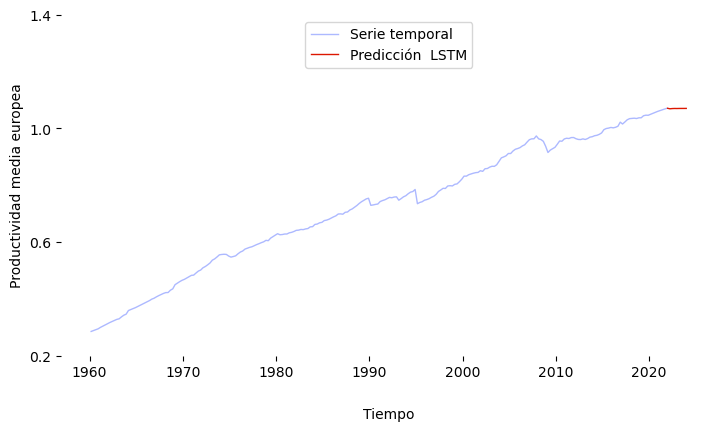

In [116]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

plt.plot(predicciones_lstm, color = LSTM_color, 
         label = 'Predicción  LSTM', lw = 1)

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.ylabel ('Productividad media europea')
plt.box(False)
plt.legend(loc = 'upper center')
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/pred_lstm', bbox_inches='tight')

plt.show()

### <a id = 'prophet'> Prophet </a>

*Prophet* (o *FB Prophet*), a diferencia de `Tensorflow`, es una librería de alto nivel, como `Sklearn`, incluso más alto que `Keras`. Esto supone que crear modelos con esta librería sea mucho más sencillo y directo; con la contraparte de no poder modificar y personalizar algunos parámetros del modelo, que con una librería de más bajo nivel (como `Tensorflow` o `Keras`) sí te lo permite. 

Algo de lo que *"presume"* *Facebook* (`Prophet` fue creado por esta compañía) es de ser una librería apta para expertos y no tan expertos.

> *Prophet makes it much more straightforward to create a reasonable, accurate forecast. With Prophet, you are not stuck with the results of a completely automatic procedure if the forecast is not satisfactory — an analyst with no training in time series methods can improve or tweak forecasts using a variety of easily-interpretable parameters.*

También algo que cabe recalcar, es que *Prophet* en una librería pensada para series temporales comunes en *Facebook*. Estas son series temporales con múltiples estacionalidades, *outliers*, etc. `serie_temporal_productividad` no cumple con estos requisitos, y *Prophet* podría no ser el mejor algoritmo para modelarla (esto no se sabía de antemano, por supuesto). 

> *Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:
hourly, daily, or weekly observations with at least a few months (preferably a year) of history strong multiple “human-scale” seasonalities: day of week and time of year important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl) a reasonable number of missing observations or large outliers historical trend changes, for instance due to product launches or logging changes trends that are non-linear growth curves, where a trend hits a natural limit or saturates*

<br>

Por último, recalcar que *Prophet* tiene sus propios gráficos para mostrar las predicciones. **Se emplearán tanto estos gráficos como los hechos por este trabajo**. 

##### División de datos en Train y Test

De nuevo, al igual que se ha hecho con *LSTM*, se procede a dividir los datos en dos conjuntos: *train* y *test*. Aunque *Prophet* normalmente **trabaja con todo el conjunto de datos**, dividir los datos será útil para posteriormente validar el modelo. Para esta división, se utilizará `len(train_lstm)` del anterior apartado.

> **Nota**: No se usa directamente la variable *train* de apartado anterior por dos motivos: El primero es que *Prophet*, al no ser una red neuronal, no trabaja con datos normalizados (el conjunto de *train* en *LSTM* eran datos normalizados). El segundo, es porque *Prophet* es necesario pasarle un *dataframe* para que pueda ajustar el modelo (se verá en el siguiente subapartado).

In [117]:
train_prophet = serie_temporal_productividad.iloc[:len(train_lstm),:]
train_prophet

,Productividad
1960-03-01,0.284764
1960-06-01,0.287928
1960-09-01,0.291303
1960-12-01,0.294081
1961-03-01,0.299138
...,...
2008-06-01,0.960729
2008-09-01,0.954564
2008-12-01,0.937034
2009-03-01,0.915270


El conjunto de *test*, en *Prophet*, no hay que especificarlo. Se validará luego cuando se hagan las predicciones  para los datos que no están en la variable `train_Prophet` (*Prophet* **no es una red neuronal**).

##### Transformaciones necesarias

Para empezar a realizar predicciones con *Prophet*, hay que modificar el *dataset*, pues *Prophet* espera un *dataframe* con las columnas `ds` para las fechas e `y` para la variable a predecir (`Productividad` en este caso).

In [118]:
ts_prophet = train_prophet.reset_index()
ts_prophet

,index,Productividad
0,1960-03-01,0.284764
1,1960-06-01,0.287928
2,1960-09-01,0.291303
3,1960-12-01,0.294081
4,1961-03-01,0.299138
...,...,...
193,2008-06-01,0.960729
194,2008-09-01,0.954564
195,2008-12-01,0.937034
196,2009-03-01,0.915270


In [119]:
ts_prophet.rename(columns = {'index':'ds', 'Productividad':'y'},
                        inplace = True)
ts_prophet

,ds,y
0,1960-03-01,0.284764
1,1960-06-01,0.287928
2,1960-09-01,0.291303
3,1960-12-01,0.294081
4,1961-03-01,0.299138
...,...,...
193,2008-06-01,0.960729
194,2008-09-01,0.954564
195,2008-12-01,0.937034
196,2009-03-01,0.915270


Adicionalmente, como se comentó en el estado de la cuestión, a *Prophet* se le pueden especificar también.
- La **capacidad máxima**. Es decir, si la predicción está acotada por arriba. En este caso, no hay una capacidad máxima.
- También se puede especificar la capacidad mínima, que en este caso **sí** la hay y es $0$.

Esto será indicado posteriormente al crear el modelo con el parámetro `growth = linear` y añadiendo la columna `floor` al *dataframe* que recibe *Prophet*.

In [120]:
ts_prophet['floor'] = 0 # capacidad mínima

También se comentó en el estado de la cuestión la posibilidad de poder añadir festivos y/o vacaciones al modelo. Se decide incluir las Navidades, ya que son de fecha fija. Para saber la fecha de inicio y fin de estas vacaciones, se utiliza la primera y última fila del `ts_prophet`

In [121]:
ts_prophet.iloc[:1]

,ds,y,floor
0,1960-03-01,0.284764,0


In [122]:
ts_prophet[-1:]

,ds,y,floor
197,2009-06-01,0.923715,0


In [123]:
fechas_navidades = pd.date_range(start = '1960-12-24', 
                                     end = '1960-12-31')
for ANIO in range(1961, 2009):
    fechas_navidades = fechas_navidades.append(pd.date_range(start = f'{ANIO}-12-24', 
                                     end = f'{ANIO}-12-31'))
    
fechas_navidades

DatetimeIndex(['1960-12-24', '1960-12-25', '1960-12-26', '1960-12-27',
               '1960-12-28', '1960-12-29', '1960-12-30', '1960-12-31',
               '1961-12-24', '1961-12-25',
               ...
               '2007-12-30', '2007-12-31', '2008-12-24', '2008-12-25',
               '2008-12-26', '2008-12-27', '2008-12-28', '2008-12-29',
               '2008-12-30', '2008-12-31'],
              dtype='datetime64[ns]', length=392, freq=None)

In [124]:
navidades = pd.DataFrame({
  'holiday': 'Navidades',
  'ds': fechas_navidades})

##### Creación del modelo

In [125]:
modelo_prophet = Prophet(growth = 'linear', holidays = navidades)

##### Ajuste del modelo

In [126]:
modelo_prophet.fit(ts_prophet)

13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:17 - cmdstanpy - INFO - Chain [1] done processing


##### Validación del modelo

Para ello, se le va a indicar a *Prophet* que realice una predicción de los valores que no estaban incluidos en `train_prophet` y se compararán con los valores reales de `serie_temporal_productividad`.

Para ello, es necesario crear un *dataframe* indicando los días de la predicción. En este *dataframe*, también se indica la capacidad mínima.

In [127]:
len_test = len(serie_temporal_productividad) - len(train_prophet)

In [128]:
test_pred = modelo_prophet.make_future_dataframe(periods = len_test, 
                                                  freq = 'Q')
test_pred['floor'] = 0
test_pred = modelo_prophet.predict(test_pred)
test_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Navidades,Navidades_lower,Navidades_upper,additive_terms,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-03-01,0.271388,0.266059,0.291681,0.271388,0.271388,0.0,0.0,0.0,0.007598,...,0.0,0.0,0.0,0.007598,0.007598,0.007598,0.0,0.0,0.0,0.278986
1,1960-06-01,0.276154,0.268999,0.295194,0.276154,0.276154,0.0,0.0,0.0,0.006711,...,0.0,0.0,0.0,0.006711,0.006711,0.006711,0.0,0.0,0.0,0.282865
2,1960-09-01,0.280920,0.276447,0.302364,0.280920,0.280920,0.0,0.0,0.0,0.008481,...,0.0,0.0,0.0,0.008481,0.008481,0.008481,0.0,0.0,0.0,0.289401
3,1960-12-01,0.285634,0.280628,0.305815,0.285634,0.285634,0.0,0.0,0.0,0.007270,...,0.0,0.0,0.0,0.007270,0.007270,0.007270,0.0,0.0,0.0,0.292904
4,1961-03-01,0.290296,0.282845,0.308829,0.290296,0.290296,0.0,0.0,0.0,0.006105,...,0.0,0.0,0.0,0.006105,0.006105,0.006105,0.0,0.0,0.0,0.296401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2020-09-30,1.154420,1.099390,1.163526,1.125392,1.184024,0.0,0.0,0.0,-0.023297,...,0.0,0.0,0.0,-0.023297,-0.023297,-0.023297,0.0,0.0,0.0,1.131122
244,2020-12-31,1.158549,1.123310,1.188446,1.128298,1.189371,0.0,0.0,0.0,-0.003749,...,0.0,0.0,0.0,-0.003749,-0.003749,-0.003749,0.0,0.0,0.0,1.154800
245,2021-03-31,1.162589,1.119314,1.184583,1.131237,1.194207,0.0,0.0,0.0,-0.012312,...,0.0,0.0,0.0,-0.012312,-0.012312,-0.012312,0.0,0.0,0.0,1.150277
246,2021-06-30,1.166673,1.125586,1.194076,1.134570,1.199064,0.0,0.0,0.0,-0.008323,...,0.0,0.0,0.0,-0.008323,-0.008323,-0.008323,0.0,0.0,0.0,1.158350


Se filtran los datos interesantes.

In [129]:
test_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1960-03-01,0.278986,0.266059,0.291681
1,1960-06-01,0.282865,0.268999,0.295194
2,1960-09-01,0.289401,0.276447,0.302364
3,1960-12-01,0.292904,0.280628,0.305815
4,1961-03-01,0.296401,0.282845,0.308829
...,...,...,...,...
243,2020-09-30,1.131122,1.099390,1.163526
244,2020-12-31,1.154800,1.123310,1.188446
245,2021-03-31,1.150277,1.119314,1.184583
246,2021-06-30,1.158350,1.125586,1.194076


En donde:
- `ds` indica la fecha.
- `yhat` indica valores *train* + valores *test*.
- `yhat_lower` indica el límite inferior del intervalo de confianza .
- `upper` indica el límite superior del intervalo de confianza .

Al igual que se hizo con *LSTM*, se calcula el *MAE* para evaluar el modelo.

In [130]:
x_train_prophet = test_pred.iloc[:len(train_prophet), test_pred.columns.get_loc('yhat')].to_numpy()
x_true = serie_temporal_productividad.iloc[:len(train_prophet), 
        serie_temporal_productividad.columns.get_loc('Productividad')].to_numpy()

In [131]:
y_test_prophet = test_pred.iloc[len(train_prophet)+1:, test_pred.columns.get_loc('yhat')].to_numpy()
y_true = serie_temporal_productividad.iloc[len(train_prophet)+1:, 
        serie_temporal_productividad.columns.get_loc('Productividad')].to_numpy()

In [132]:
mae_train_prophet = np.abs(x_train_prophet - x_true)
mae_train_prophet = np.mean(mae_train_prophet)
print(f'MAE train modelo Prophet: \033[1m{mae_train_prophet:.4f}\033[0m')

MAE train modelo Prophet: 0.0065


In [133]:
mae_test_prophet = np.abs(y_test_prophet - y_true)
mae_test_prophet = np.mean(mae_test_prophet)
print(f'MAE test modelo Prophet: \033[1m{mae_test_prophet:.4f}\033[0m')

MAE test modelo Prophet: 0.0563


En el modelo de *Prophet*, a diferencia del modelo *LSTM*, la métrica *MAE* del conjunto de *train* es menor al del conjunto de *test*, lo cual es más común. Aun así, tanto `mae_train_prophet` y `mae_test_prophet` son bastante bajos. Se considera pues, que este modelo es bueno. Véase en la siguiente gráfica cómo `modelo_prophet` ajusta a los datos de *train* y predice los datos de *test*.

Text(0.5, 1.05, 'Ajuste modelo Prophet')

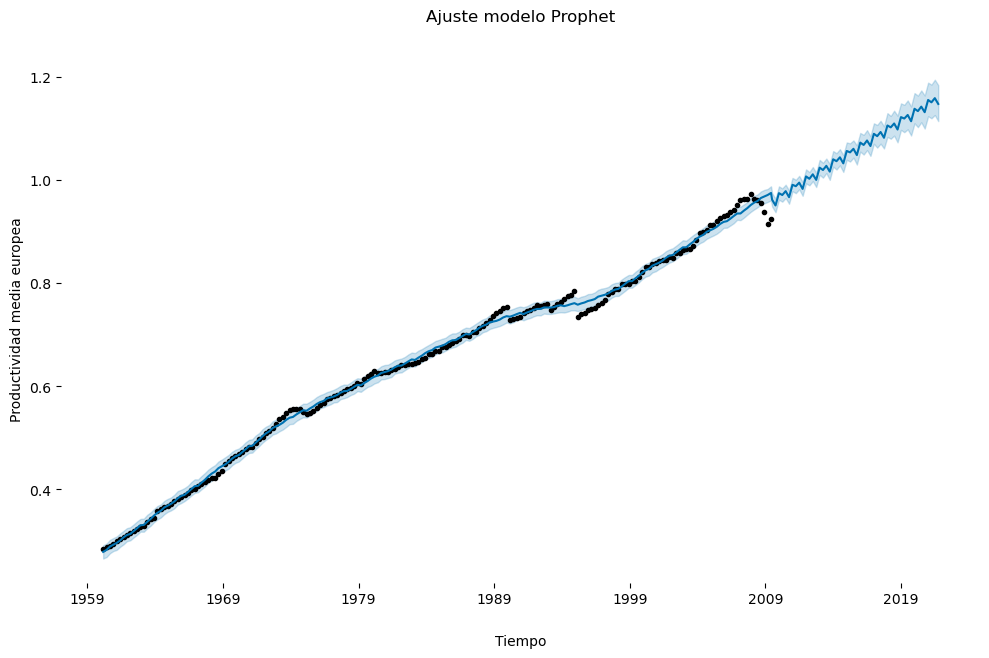

In [134]:
# Es necesario igualarlo a una variable para que no grafique dos veces
fig = modelo_prophet.plot(test_pred)
plt.box(False)
plt.grid(False)
plt.xlabel('Tiempo', labelpad = 20)
plt.ylabel('Productividad media europea')
plt.title('Ajuste modelo Prophet', y = 1.05)

In [135]:
x_train_prophet_ts = test_pred.loc[:len(train_prophet), ['ds', 'yhat']]
x_train_prophet_ts.set_index('ds', inplace = True)
x_train_prophet_ts

,yhat
ds,
1960-03-01,0.278986
1960-06-01,0.282865
1960-09-01,0.289401
1960-12-01,0.292904
1961-03-01,0.296401
...,...
2008-09-01,0.964869
2008-12-01,0.967743
2009-03-01,0.970617


In [136]:
y_test_prophet_ts = test_pred.loc[len(train_prophet)+1:, ['ds', 'yhat']]
y_test_prophet_ts.set_index('ds', inplace = True)
y_test_prophet_ts

,yhat
ds,
2009-09-30,0.950370
2009-12-31,0.974251
2010-03-31,0.970612
2010-06-30,0.978100
2010-09-30,0.966388
2010-12-31,0.990434
2011-03-31,0.987716
2011-06-30,0.994597
2011-09-30,0.982446


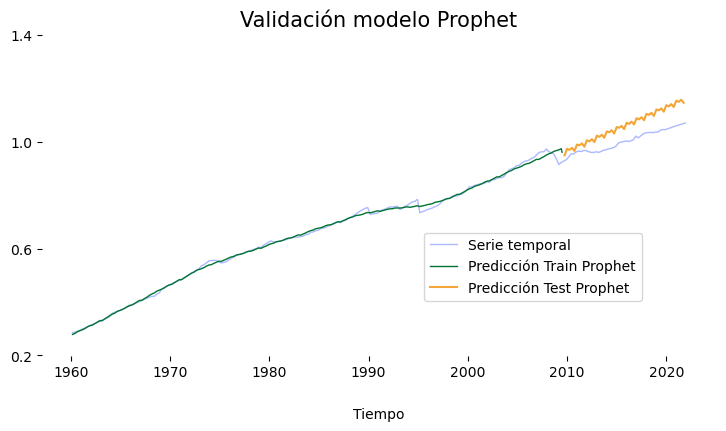

In [137]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

plt.plot(x_train_prophet_ts, color = TRAIN_color, 
         label = 'Predicción Train Prophet', lw = 1)

plt.plot(y_test_prophet_ts, color = TEST_color,
        label = 'Predicción Test Prophet')

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Validación modelo Prophet', 
          fontsize = 15)
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/ajuste_prophet', bbox_inches='tight')

plt.show()

En esta gráfica se ve muy bien el problema que está habiendo con la predicción: el modelo no está ajustando bien el pico que hay alrededor del año $2008$, y por esto el conjunto *test* está sobreestimando los datos. En el estado de la cuestión, se comentó que *Prophet* utiliza **puntos de inflexión** para crear el modelo. Estos **puntos de inflexión** detectan cambios en la tendencia y la línea verde (i.e. `x_train_prophet`) se ve claramente cómo no está cogiendo bien el pico de 2008. Esto se puede ver mucho mejor gráficamente en el siguiente gráfico, en donde las líneas verticales rojas indican <u> puntos de inflexión que</u> `modelo_prophet` <u>ha detectado</u>.

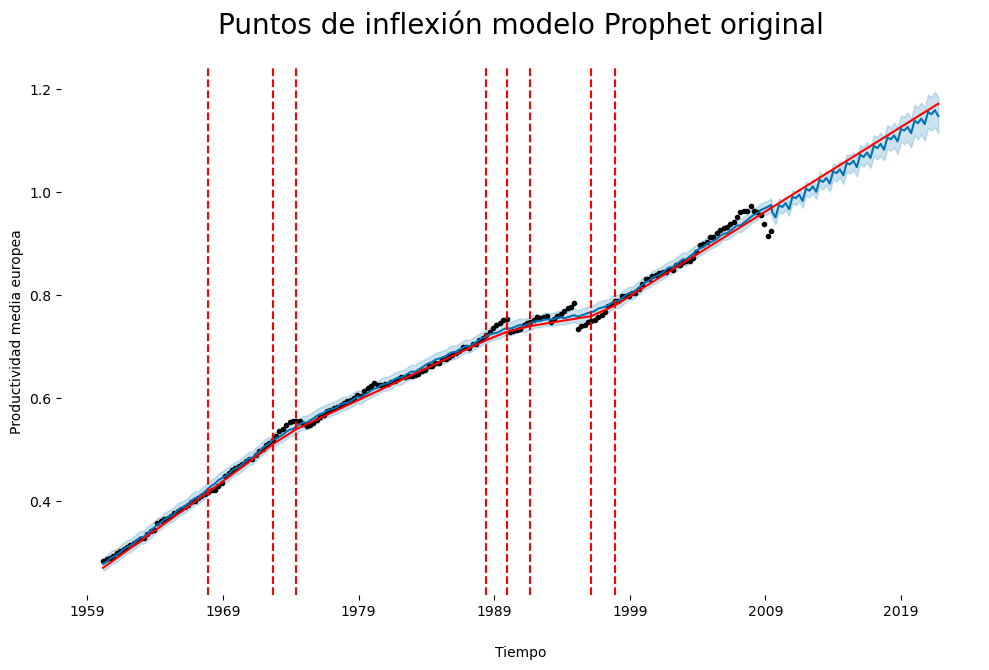

In [138]:
fig = modelo_prophet.plot(test_pred)
checkpoints = add_changepoints_to_plot(fig.gca(), modelo_prophet, 
                                       test_pred)
plt.box(False)
plt.grid(False)
plt.xlabel('Tiempo', labelpad = 20)
plt.ylabel('Productividad media europea')
plt.title('Puntos de inflexión modelo Prophet original', y = 1.05, fontsize= 20)

#plt.savefig('../Documento/imgs_desarrollo/puntos_inf_prophet', bbox_inches='tight')

plt.show()

Aquí se aprecia claramente cómo `modelo_prophet` no alcanza a detectar el pico alrededor del año $2007$/$2008$. Esto es normal teniendo en cuenta que *Prophet* solo tiene en cuenta puntos de inflexión de los primeros $80\%$ de los datos con los que se entrena (y el pico está en los últimos datos). Esto se puede cambiar con `changepoint_range` al crear el modelo *Prophet*. Se va a probar a crear un nuevo modelo que trate de mejorar las predicciones del anterior estableciendo `changepoint_range=0.99`. Adicionalmente,como en la gráfica anterior parece que *Prophet* detecta demasiados cambios de tendencia, muchos de ellos mínimos, se establece `changepoint_prior_scale` para establecer un modelo menos flexible y, por tanto, más simple. 

> **Nota**: *Prophet* los esparce aleatoriamente y solo marca (con líneas rojas  verticales discontinuas) aquellos que son significativos. 

Se vuelven a repetir los pasos hechos hasta ahora.

In [139]:
# Creación del modelo
modelo_prophet_mejorado = Prophet(growth = 'linear', holidays = navidades,
                         changepoint_range=0.99, changepoint_prior_scale=0.03)

In [140]:
# Ajuste del modelo
modelo_prophet_mejorado.fit(ts_prophet)

13:50:20 - cmdstanpy - INFO - Chain [1] start processing
13:50:20 - cmdstanpy - INFO - Chain [1] done processing


In [141]:
# Resultados del modelo
test_pred = modelo_prophet_mejorado.make_future_dataframe(periods = len_test, 
                                                  freq = 'Q')
test_pred['floor'] = 0
test_pred = modelo_prophet_mejorado.predict(test_pred)
test_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1960-03-01,0.278933,0.267372,0.290606
1,1960-06-01,0.282979,0.271344,0.294948
2,1960-09-01,0.289277,0.277408,0.301043
3,1960-12-01,0.292805,0.281019,0.304467
4,1961-03-01,0.296295,0.283853,0.308365
...,...,...,...,...
243,2020-09-30,1.026791,0.991642,1.063856
244,2020-12-31,1.059949,1.024670,1.097346
245,2021-03-31,1.055739,1.018583,1.095861
246,2021-06-30,1.053489,1.016275,1.094243


##### Validación del modelo (continuación)

In [142]:
x_train_prophet_mejorado = test_pred.iloc[:len(train_prophet), test_pred.columns.get_loc('yhat')].to_numpy()

In [143]:
y_test_prophet_mejorado = test_pred.iloc[len(train_prophet)+1:, test_pred.columns.get_loc('yhat')].to_numpy()

In [144]:
mae_train_prophet_mejorado = np.abs(x_train_prophet_mejorado - x_true)
mae_train_prophet_mejorado = np.mean(mae_train_prophet_mejorado)
print(f'MAE train modelo Prophet: \033[1m{mae_train_prophet_mejorado:.4f}\033[0m')

MAE train modelo Prophet: 0.0062


In [145]:
mae_test_prophet_mejorado = np.abs(y_test_prophet_mejorado - y_true)
mae_test_prophet_mejorado = np.mean(mae_test_prophet_mejorado)
print(f'MAE test modelo Prophet: \033[1m{mae_test_prophet_mejorado:.4f}\033[0m')

MAE test modelo Prophet: 0.0138


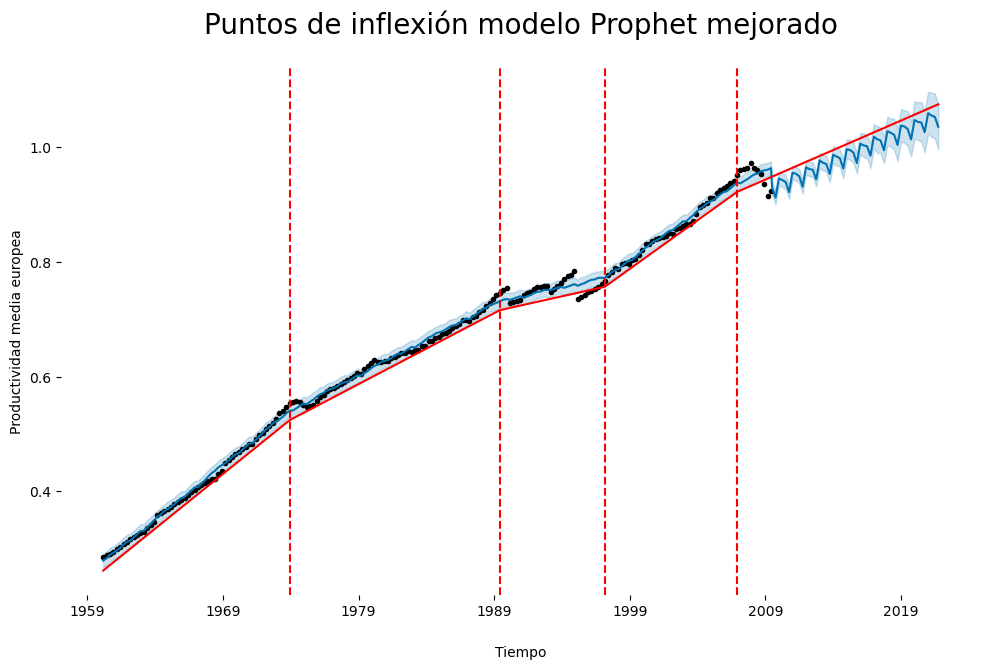

In [146]:
fig = modelo_prophet_mejorado.plot(test_pred)
checkpoints = add_changepoints_to_plot(fig.gca(), modelo_prophet_mejorado, 
                                       test_pred)
plt.box(False)
plt.grid(False)
plt.xlabel('Tiempo', labelpad = 20)
plt.ylabel('Productividad media europea')
plt.title('Puntos de inflexión modelo Prophet mejorado', y = 1.05, fontsize = 20)

#plt.savefig('../Documento/imgs_desarrollo/puntos_inf_prophet_mejorado', bbox_inches='tight')

plt.show()

Se puede ver que con los cambios comentados anteriormente, el modelo parece predecir mejor. Además, sus valores de `mae train_prophet_mejorado` y `mae test_prophet_mejorado` son mejores respecto de los del modelo anterior. Véase la siguiente tabla.

In [147]:
resultados_mae = {
    ('Original', ''): ['{:.4f}'.format(mae_train_prophet), '{:.4f}'.format(mae_test_prophet)],
    ('Mejorado', ''): ['{:.4f}'.format(mae_train_prophet_mejorado), '{:.4f}'.format(mae_test_prophet_mejorado)]
}

index = pd.MultiIndex.from_tuples(resultados_mae.keys(), names=['Modelo Prophet', None])

comparativa_prophet = pd.DataFrame(resultados_mae.values(), index=index, columns=['MAE train', 'MAE test'])

comparativa_prophet

,,MAE train,MAE test
Modelo Prophet,,,
Original,,0.0065,0.0563
Mejorado,,0.0062,0.0138


Luego, pese a que el anterior modelo era un buen modelo, este es mejor. Se puede volver a ver el ajuste de *train* y *test* de `modelo_prophet_mejorado` en la siguiente gráfica.

In [148]:
x_train_prophet_ts = test_pred.loc[:len(train_prophet), ['ds', 'yhat']]
x_train_prophet_ts.set_index('ds', inplace = True)
y_test_prophet_ts = test_pred.loc[len(train_prophet)+1:, ['ds', 'yhat']]
y_test_prophet_ts.set_index('ds', inplace = True)

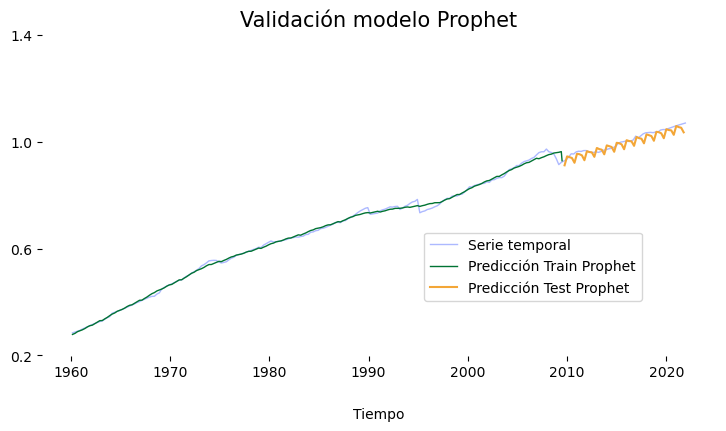

In [149]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

plt.plot(x_train_prophet_ts, color = TRAIN_color,
         label = 'Predicción Train Prophet', lw = 1)

plt.plot(y_test_prophet_ts, color = TEST_color,
        label = 'Predicción Test Prophet')

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Validación modelo Prophet', 
          fontsize = 15)
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/ajuste_prophet_mejorado', bbox_inches='tight')

plt.show()

##### Predicciones con Prophet

Para hacer predicciones a futuro, se debe hacer lo mismo que se ha hecho para extraer los valores del conjunto *test*, pero ahora añadiendo el periodo futuro sobre el que se quiere predecir. Se recuerda que este periodo es de $8$ trimestres (2 años).

In [150]:
# +9 es proque el indice empieza en 0 y no en 1
predicciones_prophet = modelo_prophet_mejorado.make_future_dataframe(periods = len_test+9,
                                                                     freq = 'Q')

predicciones_prophet['floor'] = 0
predicciones_prophet = modelo_prophet_mejorado.predict(predicciones_prophet)
predicciones_prophet = predicciones_prophet[['ds','yhat']][-9:]
predicciones_prophet.set_index('ds', inplace = True)
predicciones_prophet

,yhat
ds,
2021-12-31,1.069647
2022-03-31,1.066790
2022-06-30,1.063501
2022-09-30,1.045696
2022-12-31,1.079352
2023-03-31,1.077891
2023-06-30,1.073548
2023-09-30,1.055238
2023-12-31,1.089066


Se cogen los $9$ últimos periodos para que la predicción sea continua  con respecto a la serie temporal.

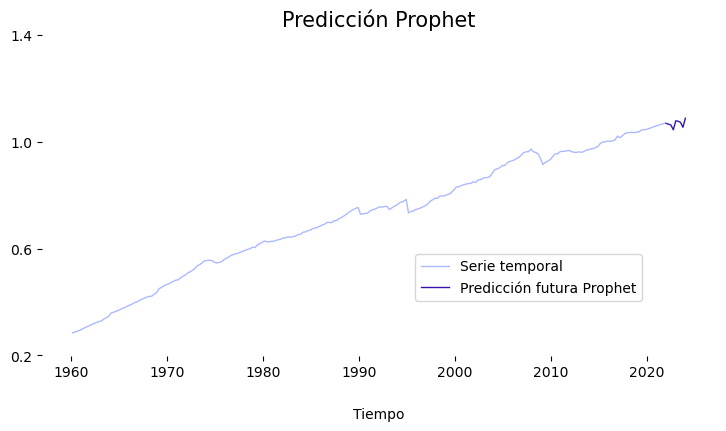

In [151]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

plt.plot(predicciones_prophet, color = PROPHET_color, 
         label = 'Predicción futura Prophet', lw = 1)

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Predicción Prophet', 
          fontsize = 15)
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/pred_prophet', bbox_inches='tight')

plt.show()

## <a id = 'comp'> Comparativa de modelos <a>

A la hora de evaluar modelos en aprendizaje automático, hay que tener muy en cuenta qué se está tratando de predecir. Hay distintos tipos de predicción. Se parte de la base de que el aprendizaje puede ser supervisado o no supervisado. Las series temporales, como cada valor tiene una etiqueta asociada a ella (el tiempo) entra dentro del campo de aprendizaje supervisado. Dentro de este campo, el tipo de predicciones más comunes son: clasificación, regresión y series temporales. La principal diferencia entre estos dos últimos es que el orden de los datos importa (por eso, al hacer la función `train_test_split` en `Keras` es muy importante indicar `shuffle = False`).

Dependiendo de la predicción, existen distintas métricas de evaluación de modelos. Las técnicas más comunes, aplicadas en regresión, también se pueden aplicar para series temporales. En el caso concreto de este trabajo, si se ha seguido el código, se ha podido comprobar que **se ha optado por utilizar** *MAE* (*Mean Absolute Error*) por dos motivos: su popularidad y su fácil interpretación:

<br>

<div style="text-align: center;">
    <span style="font-size:16px;">$MAE = \frac{1}{n} \sum_{N}^{i=1} \left |  y_i-x_i\right |$</span>
</div>
    
<br>

Algo a tener muy en cuenta es la difícil comparación entre el modelo *ARIMA* con el resto de modelos. Si bien *ARIMA* se puede evaluar aplicando la métrica *MAE*, no es muy común hacerlo de esta manera. *ARIMA*, al tener fundamentos estadísticos, la manera más correcta y más común de evaluar un modelo es a través de varios contrastes de hipótesis; muchos de ellos centrándose en el componente residual de la serie temporal.  

Pese a que *ARIMA* no se ha evaluado con *MAE*, se va a calcular el *MAE* de `modelo_arima` con los mismos datos de *train* y *test* que en los modelos *LSTM* y *Prophet* para poder compararlos de una manera más sencilla, pero hay que tener en cuenta que *ARIMA* no se ha dividido en conjuntos de datos *train* y *test*.

In [152]:
modelo_arima_df = modelo_arima.to_frame(name = 'Values')[1:]

x_train_arima = modelo_arima_df.iloc[:len(train_prophet)-1, 0].to_numpy()
y_test_arima =  modelo_arima_df.iloc[len(train_prophet):, 0].to_numpy()

mae_train_arima = np.abs(x_train_arima - x_true[1:])
mae_train_arima = np.mean(mae_train_arima)
print(f'MAE train modelo Prophet: \033[1m{mae_train_arima:.4f}\033[0m')

mae_test_arima = np.abs(y_test_arima - y_true[1:])
mae_test_arima = np.mean(mae_test_arima)
print(f'MAE test modelo Prophet: \033[1m{mae_test_arima:.4f}\033[0m')

MAE train modelo Prophet: 0.0034
MAE test modelo Prophet: 0.0031


Adicionalmente, en caso de que se haya ejecutado este notebook y se haya obtenido otro modelo *LSTM* al empleado en el TFG, se incluirá el modelo del TFG en la comparativa.

In [153]:
modelo_tfg  = load_model('modelos_LSTM/modelo_tfg.h5')

In [154]:
y_train_lstm = modelo_tfg.predict(train_generator)
y_test_lstm = modelo_tfg.predict(test_generator)
y_train_lstm = min_max_scaler.inverse_transform(y_train_lstm.reshape(-1, 1))
y_test_lstm = min_max_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
mae_train_lstm_tfg = mean_absolute_error(y_true=train_lstm[num_datos_pasados:], y_pred=y_train_lstm)
mae_test_lstm_tfg = mean_absolute_error(y_true=test_lstm[num_datos_pasados:], y_pred=y_test_lstm)
print(f'\nMAE - Train: {mae_train_lstm_tfg}')
print(f'MAE - Test:  {mae_test_lstm_tfg}')

47/47 [==============================] - 0s 4ms/step

MAE - Train: 0.2579558602405435
MAE - Test:  0.11008531895082901


Una vez se tiene estos datos, se van a comparar cuatro modelos:
- ARIMA(1,1,1)
- LSTM ejecutado en este notebook
- LSTM del modelo TFG 
- Prophet mejorado (segundo modelo)

In [155]:
comparativa = {
    ('ARIMA', ''): ['{:.4f}'.format(mae_train_arima), '{:.4f}'.format(mae_test_arima)],
    ('LSTM actual', ''): ['{:.4f}'.format(mae_train_lstm), '{:.4f}'.format(mae_test_lstm)],
    ('LSTM TFG', ''): ['{:.4f}'.format(mae_train_lstm_tfg), '{:.4f}'.format(mae_test_lstm_tfg)],
    ('Prophet', ''): ['{:.4f}'.format(mae_train_prophet_mejorado), '{:.4f}'.format(mae_test_prophet_mejorado)]
}

index = pd.MultiIndex.from_tuples(comparativa.keys(), names=['Modelos', ''])

comparativa_df = pd.DataFrame(comparativa.values(), index=index, columns=['MAE train', 'MAE test'])

comparativa_df

,,MAE train,MAE test
Modelos,,,
ARIMA,,0.0034,0.0031
LSTM actual,,0.2580,0.1101
LSTM TFG,,0.2580,0.1101
Prophet,,0.0062,0.0138


In [156]:
peores_resultados = comparativa_df.style.highlight_max(axis=0,props='color:black; font-weight:bold; background-color:orange')
peores_resultados

,,MAE train,MAE test
Modelos,,,
ARIMA,,0.0034,0.0031
LSTM actual,,0.2580,0.1101
LSTM TFG,,0.2580,0.1101
Prophet,,0.0062,0.0138


In [157]:
mejores_resultados = comparativa_df.style.highlight_min(axis=0,props='color:white; font-weight:bold; background-color:green')
mejores_resultados

,,MAE train,MAE test
Modelos,,,
ARIMA,,0.0034,0.0031
LSTM actual,,0.2580,0.1101
LSTM TFG,,0.2580,0.1101
Prophet,,0.0062,0.0138


Los colores reflejan de una manera muy clara cuál ha sido el mejor y peor modelo en este trabajo. 

## <a id = 'concl'> Conclusiones </a>

En este trabajo se han podido comparar $3$ modelos de tres épocas completamente distintas: *ARIMA* de los $70'$, *LSTM* de finales de los $90'$ y *Prophet* del año $2017$. 

Estos $3$ modelos están entre los modelos estado del arte hoy en día, junto con otros como pueden ser los *Transformer* (se están estudiando mucho actualmente para mejorar su aplicación en series temporales) o las *TCN (Temporal Convolutional Network*). 

Cada modelo en este trabajo tiene sus ventajas y desventajas y los resultados de este trabajo no tienen por qué ser los mismos para otras series temporales. Por ejemplo, el modelo *ARIMA* no es recomendable utilizarlo cuando la serie temporal presenta valores atípicos frecuentes, mientras que *Prophet* no tiene problema con ellos. Además, *Prophet*, a diferencia de *ARIMA* y *LSTM*, es más sencillo de utilizar por personas *no tan expertas* en el campo de la predicción, pues ofrece, como se ha podido ver, parámetros mucho más intuitivos, y sin necesidad de tener pleno conocimiento en *ARIMA* o en redes neuronales; dos temas bastante complejos. 

Por otro lado, seguramente en series temporales en las que datos de varios periodos previos sean de importancia para predecir un dato futuro, seguramente las *LSTM* ofrezca mejores resultados. 

En otras palabras, los resultados obtenidos por estos modelos no deben ser extrapolados a otras series temporales y cada una de estas necesitará un estudio aparte y específico. 

Por último, se deja una gráfica con las predicciones de los 3 modelos.

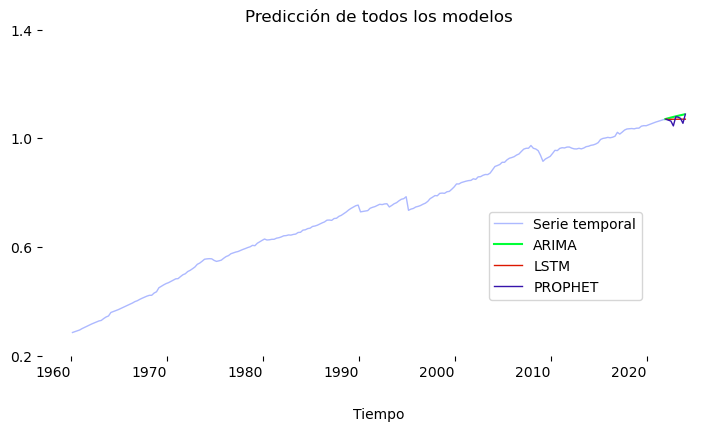

In [158]:
plt.plot(serie_temporal_productividad, color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

forecast_8_periodos_real.plot(color = ARIMA_color, label = 'ARIMA')

plt.plot(predicciones_lstm, color = LSTM_color, 
         label = 'LSTM', lw = 1)

plt.plot(predicciones_prophet, color = PROPHET_color, 
         label = 'PROPHET', lw = 1)

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Predicción de todos los modelos')
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/pred_modelos1', bbox_inches='tight')

plt.show()

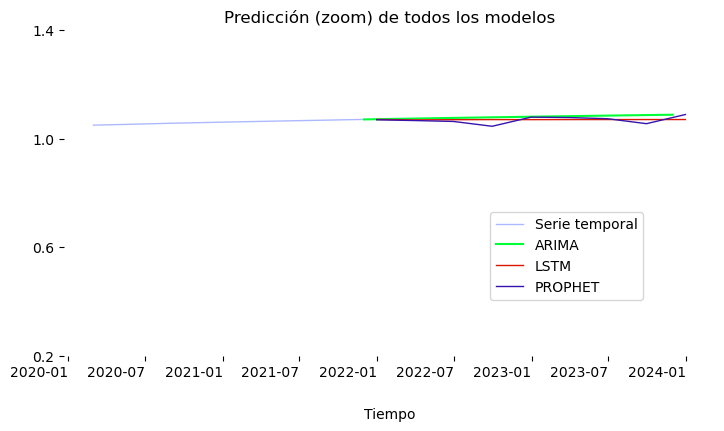

In [159]:
plt.plot(serie_temporal_productividad[240:], color = AZUL_OSCURO, 
         label = 'Serie temporal', alpha = 0.4, lw = 1)

forecast_8_periodos_real.plot(color = ARIMA_color, label = 'ARIMA')

plt.plot(predicciones_lstm, color = LSTM_color, 
         label = 'LSTM', lw = 1)

plt.plot(predicciones_prophet, color = PROPHET_color, 
         label = 'PROPHET', lw = 1)

plt.ylim(0.2, 1.3)
plt.yticks(plt.yticks()[0][::2])
plt.xticks(rotation = 0)
plt.xlabel('Tiempo', labelpad = 20) # labelpad para espaciado
plt.box(False)
plt.legend(loc = 'lower right', bbox_to_anchor = (0.9, 0.15))
plt.title('Predicción (zoom) de todos los modelos')
plt.tight_layout(rect=[0, 0.03, 1.15, 0.95]) # + espacio entre titulo y graficas

#plt.savefig('../Documento/imgs_desarrollo/pred_modelos2',  bbox_inches='tight')

plt.show()